In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tsai.all as ts
import torch
from torch import nn
from my_utilities import time_frequency_analysis, mma_Partition, time_frequency_analysis_output_1s
from sklearn.linear_model import RidgeClassifierCV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tsai.all as ts
import torch
from torch import nn
from my_utilities import time_frequency_analysis, mma_Partition, time_frequency_analysis_output_1s
from sklearn.linear_model import RidgeClassifierCV
from scipy import stats

from sklearn.metrics import confusion_matrix
import time

import mne

In [ ]:
srate = 2000
new_srate = 200
sec = 4 # time step length
ele = pd.read_csv('data/ele_4_60_hz.csv', header = None, index_col = None).to_numpy()
# shape = (4, 15, 2, 20000, 14)

ele = np.reshape(
    ele, (20000,15,4,2,14), order = 'F')\
    .transpose([2,1,3,0,4])[:,:,:,srate:-srate:srate//new_srate,:]


ear_ele = ele[...,:8].astype(np.float32).reshape(-1,int(200 * sec),8)
# head_ele = ele[...,8:].astype(np.float32).reshape(-1,int(200 * sec),6)
ear_ele.shape

(240, 800, 8)

In [183]:
ear_raw = mne.io.RawArray(np.vstack(ear_ele).T,  
                          mne.create_info(ch_names= 8, sfreq = new_srate, ch_types='eeg'))

# ear_raw = mne.io.RawArray(np.vstack(head_ele).T,  
#                           mne.create_info(ch_names= 6, sfreq = new_srate, ch_types='eeg'))

Creating RawArray with float64 data, n_channels=8, n_times=192000
    Range : 0 ... 191999 =      0.000 ...   959.995 secs
Ready.


In [184]:
ica = mne.preprocessing.ICA(
    n_components=8, method='picard', max_iter='auto', random_state=97)

In [185]:
ica.fit(ear_raw)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 1.7s.


Method,picard
Fit,27 iterations on raw data (192000 samples)
ICA components,8
Available PCA components,8
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=8, n_times=192000
    Range : 0 ... 191999 =      0.000 ...   959.995 secs
Ready.


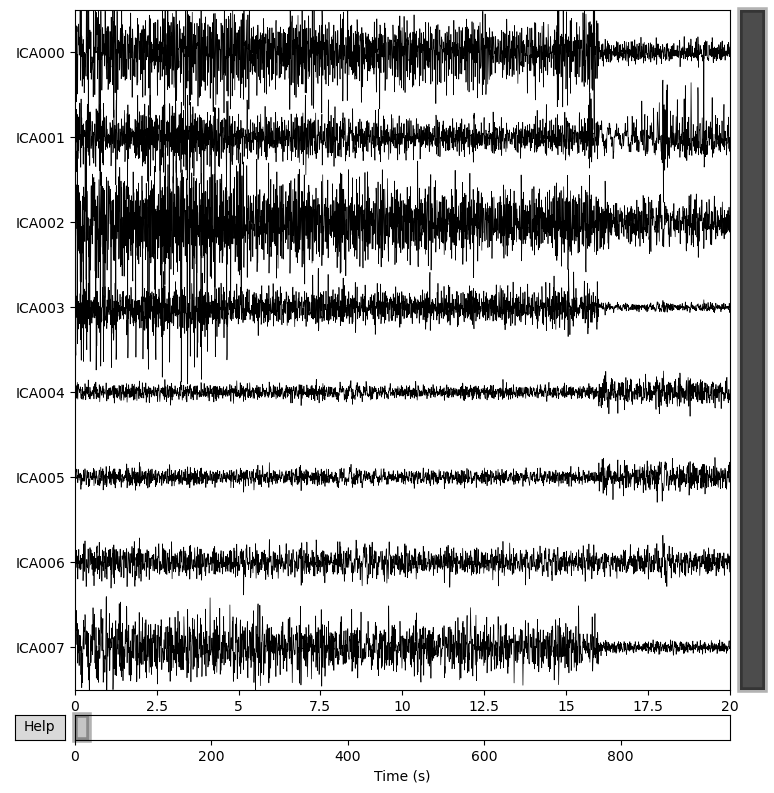

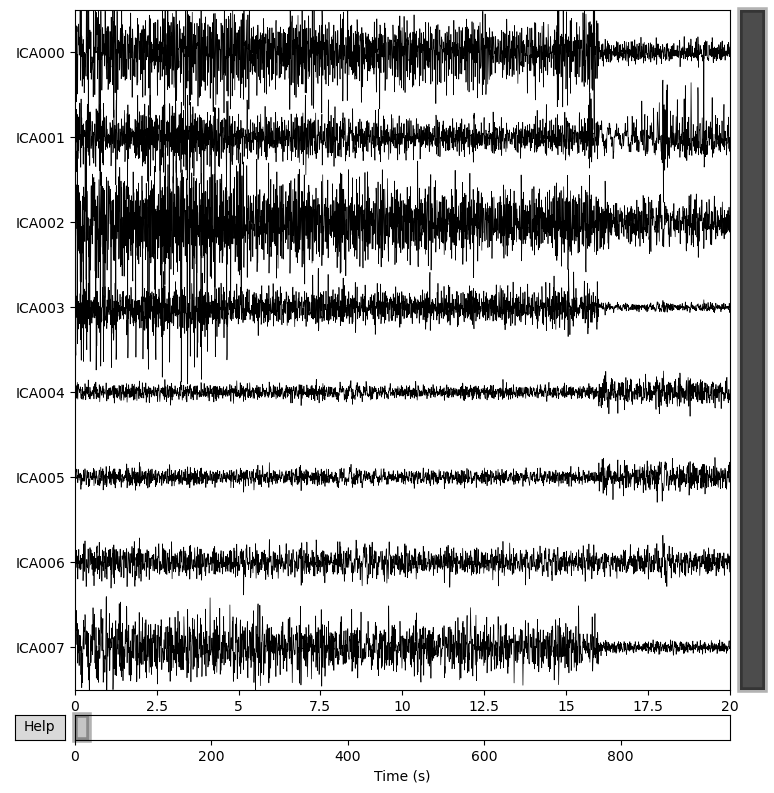

In [186]:
ica.plot_sources(ear_raw)

(1080, 200, 8)

In [160]:
# ear_5hz = removed_earEEG.reshape(4, -1, 200, 8)[0]
# ear_7hz = removed_earEEG.reshape(4, -1, 200, 8)[1]
# ear_9hz = removed_earEEG.reshape(4, -1, 200, 8)[2]
# ear_11hz = removed_earEEG.reshape(4, -1, 200, 8)[3]

In [161]:
# from tensorflow.data import Dataset

In [162]:
# # i=3
# xx1, yy1, zz1 = time_frequency_analysis(ear_7hz[i], 
#                                         srate = new_srate, 
#                                         min_freq = 2, max_freq = 60, num_freq = 59, fwhm = 3)
# xx2, yy2, zz2 = time_frequency_analysis(ear_11hz[i], 
#                                         srate = new_srate,  
#                                         min_freq = 2, max_freq = 60, num_freq = 59, fwhm = 3)
# # zz1[:3] = 0
# # zz2[:3] = 0


# plt.figure(1, figsize = (15, 8))
# plt.clf()
# plt.subplot(1,2,1)
# plt.contourf(xx1, yy1[3:], zz1[3:],
#              40, cmap=cm.jet)  # , vmin = 0, vmax = 2)
# plt.yticks(ticks = np.arange(5,61,1))
# plt.colorbar()
# plt.title('7hz')

# plt.subplot(1,2,2)
# plt.contourf(xx2, yy2[3:], zz2[3:],
#              40, cmap=cm.jet)  # , vmin = 0, vmax = 2)
# plt.yticks(ticks = np.arange(5,61,1))
# plt.colorbar()
# plt.title('11hz')
# plt.show()
# i += 1
# # plt.savefig('paper/5hz_4s.png')

In [170]:
def cross_validation(x1, y, cv_number = 20, test_size = 0.1):
    acc = []
    batch_tfms = [ts.TSStandardize(by_sample=True)]
    tfms  = [None, [ts.Categorize()]]
    cfm = np.zeros([4,4])
    for _ in np.arange(cv_number):
        x1,  y = shuffle(x1, y)
        splits = ts.get_splits(y, valid_size= test_size, stratify=True, shuffle=True)
            

        dls_x1 = ts.get_ts_dls(x1, y, 
                         splits=splits, 
                         tfms=tfms, drop_last=False, 
                         shuffle_train=False, batch_tfms=batch_tfms, bs=10_000)
        
        
        for dls in [dls_x1]:
            model = ts.build_ts_model(ts.ROCKET, dls=dls)

            X_train, y_train = ts.create_rocket_features(dls.train, model)
            X_valid, y_valid = ts.create_rocket_features(dls.valid, model)
            X_train.shape, X_valid.shape

            ridge = RidgeClassifierCV(alphas=np.logspace(-8, 8, 17), normalize=True)
            ridge.fit(X_train, y_train)
            print(f'alpha: {ridge.alpha_:.2E}  train: {ridge.score(X_train, y_train):.5f}  valid: {ridge.score(X_valid, y_valid):.5f}')
            acc.append(ridge.score(X_valid, y_valid))

            cfm += confusion_matrix(y_valid, ridge.predict(X_valid))
            print(cfm)
    return acc, cfm

In [164]:
removed_earEEG.shape

(1080, 200, 8)

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components


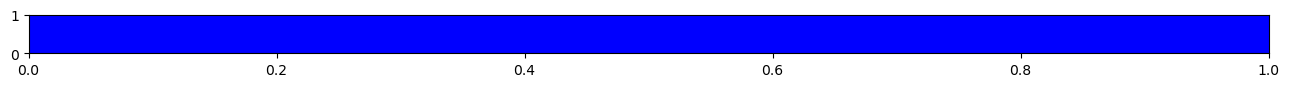

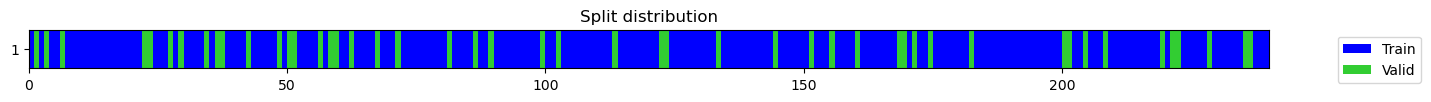

alpha: 1.00E+02  train: 0.94271  valid: 0.72917
[[ 9.  1.  2.  0.]
 [ 0. 10.  1.  1.]
 [ 3.  1.  6.  2.]
 [ 2.  0.  0. 10.]]


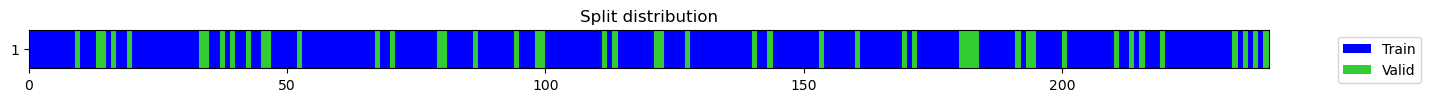

alpha: 1.00E+02  train: 0.95312  valid: 0.62500
[[17.  3.  4.  0.]
 [ 1. 19.  3.  1.]
 [ 6.  3. 11.  4.]
 [ 5.  0.  1. 18.]]


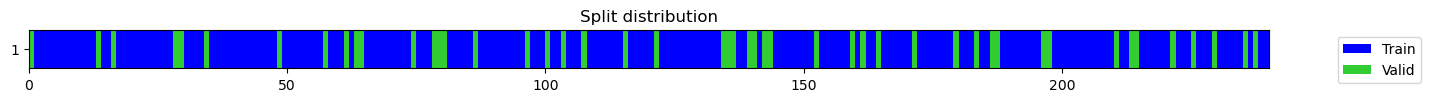

alpha: 1.00E+02  train: 0.93750  valid: 0.75000
[[24.  3.  8.  1.]
 [ 3. 27.  5.  1.]
 [ 6.  3. 23.  4.]
 [ 6.  1.  2. 27.]]


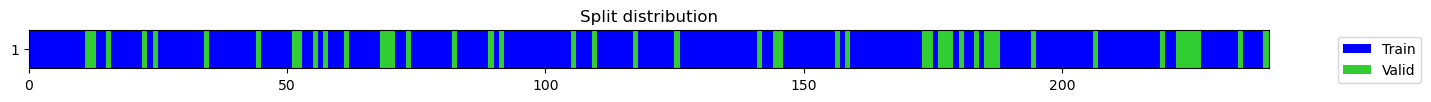

alpha: 1.00E+02  train: 0.92188  valid: 0.79167
[[32.  5. 10.  1.]
 [ 5. 37.  5.  1.]
 [ 7.  4. 32.  5.]
 [ 6.  1.  3. 38.]]


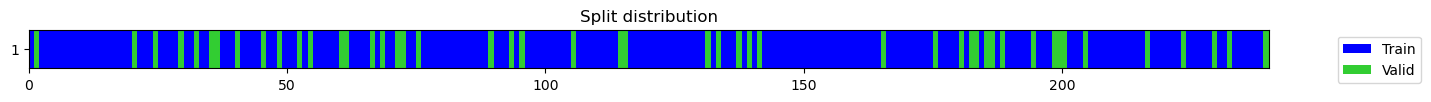

alpha: 1.00E+02  train: 0.94271  valid: 0.54167
[[38.  7. 11.  4.]
 [ 7. 44.  7.  2.]
 [ 9.  7. 38.  6.]
 [ 8.  3.  4. 45.]]


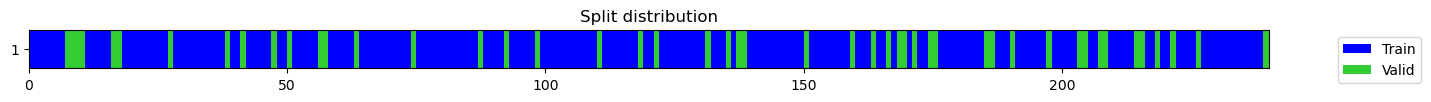

alpha: 1.00E+02  train: 0.93229  valid: 0.70833
[[45. 10. 12.  5.]
 [ 7. 55.  8.  2.]
 [11.  8. 45.  8.]
 [11.  3.  4. 54.]]


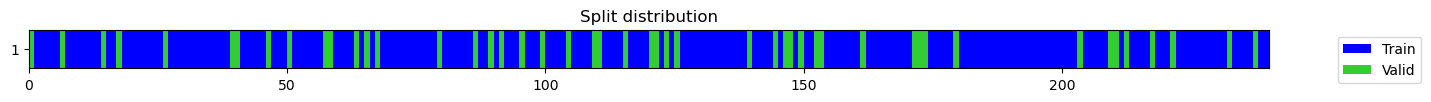

alpha: 1.00E+02  train: 0.94792  valid: 0.60417
[[50. 13. 14.  7.]
 [ 8. 64. 10.  2.]
 [15.  9. 51.  9.]
 [14.  3.  4. 63.]]


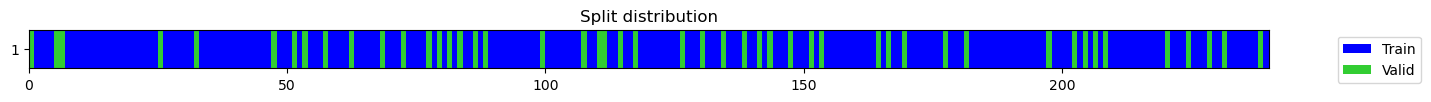

alpha: 1.00E+02  train: 0.93229  valid: 0.66667
[[57. 16. 15.  8.]
 [ 9. 73. 11.  3.]
 [17.  9. 60. 10.]
 [16.  3.  7. 70.]]


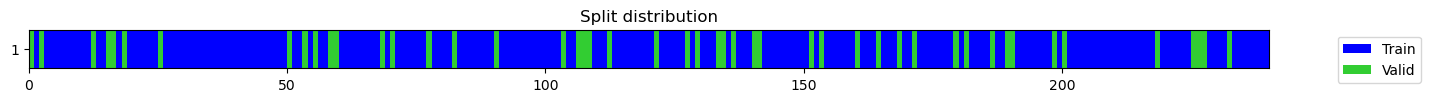

alpha: 1.00E+02  train: 0.92188  valid: 0.68750
[[65. 18. 17.  8.]
 [11. 80. 13.  4.]
 [20. 11. 67. 10.]
 [17.  3.  7. 81.]]


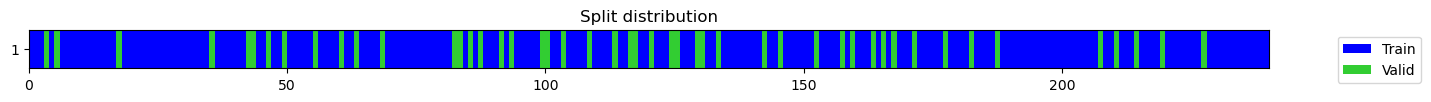

alpha: 1.00E+02  train: 0.92708  valid: 0.70833
[[71. 20. 21.  8.]
 [11. 91. 14.  4.]
 [22. 12. 74. 12.]
 [19.  3.  7. 91.]]


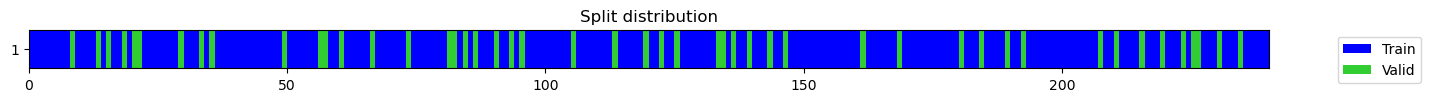

alpha: 1.00E+02  train: 0.94271  valid: 0.68750
[[ 78.  22.  24.   8.]
 [ 14.  99.  14.   5.]
 [ 24.  13.  83.  12.]
 [ 21.   3.   8. 100.]]


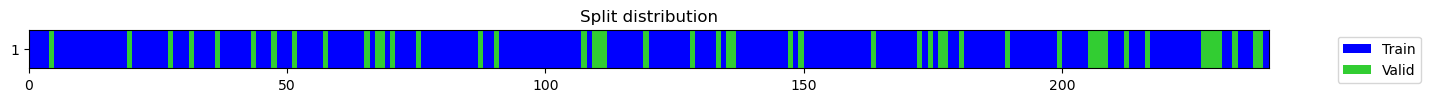

alpha: 1.00E+02  train: 0.93750  valid: 0.62500
[[ 86.  22.  28.   8.]
 [ 17. 106.  14.   7.]
 [ 25.  14.  92.  13.]
 [ 22.   5.  11. 106.]]


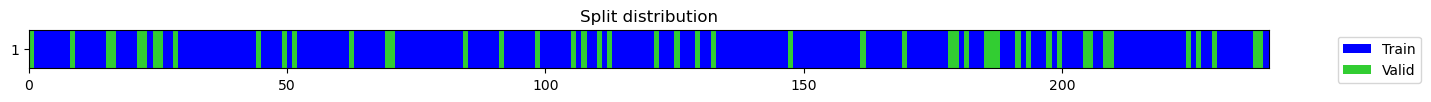

alpha: 1.00E+02  train: 0.92708  valid: 0.77083
[[ 95.  25.  28.   8.]
 [ 17. 117.  15.   7.]
 [ 27.  17.  99.  13.]
 [ 23.   6.  11. 116.]]


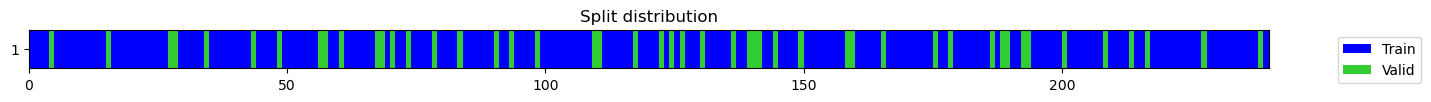

alpha: 1.00E+01  train: 1.00000  valid: 0.60417
[[101.  27.  32.   8.]
 [ 19. 125.  17.   7.]
 [ 29.  19. 105.  15.]
 [ 23.   7.  13. 125.]]


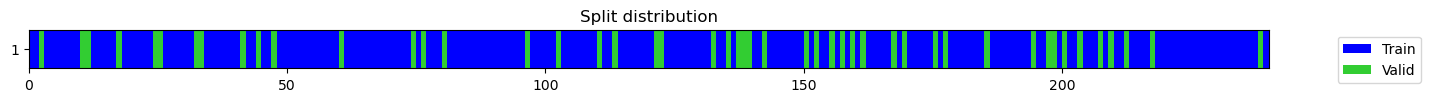

alpha: 1.00E+02  train: 0.91667  valid: 0.70833
[[108.  30.  34.   8.]
 [ 20. 134.  19.   7.]
 [ 31.  19. 114.  16.]
 [ 24.   9.  13. 134.]]


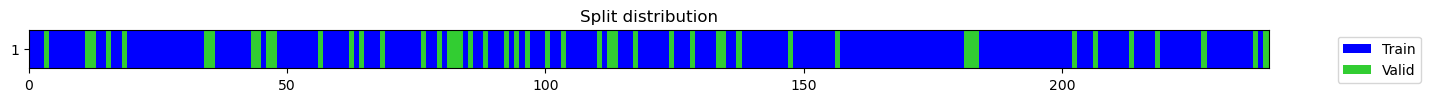

alpha: 1.00E+02  train: 0.92188  valid: 0.62500
[[113.  30.  40.   9.]
 [ 21. 143.  21.   7.]
 [ 32.  21. 121.  18.]
 [ 25.   9.  15. 143.]]


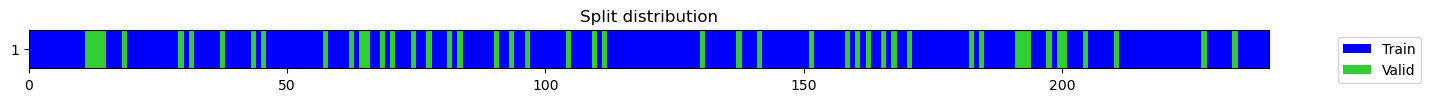

alpha: 1.00E+02  train: 0.93229  valid: 0.75000
[[122.  32.  40.  10.]
 [ 21. 154.  22.   7.]
 [ 33.  23. 129.  19.]
 [ 27.  10.  16. 151.]]


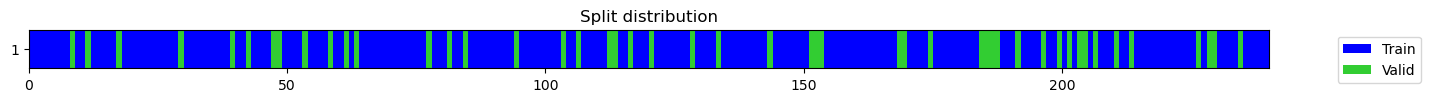

alpha: 1.00E+02  train: 0.93229  valid: 0.58333
[[129.  33.  42.  12.]
 [ 26. 160.  23.   7.]
 [ 36.  25. 136.  19.]
 [ 27.  13.  17. 159.]]


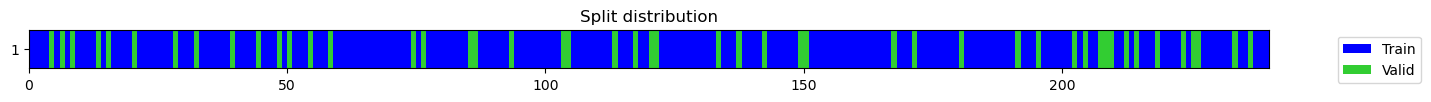

alpha: 1.00E+02  train: 0.92188  valid: 0.77083
[[138.  33.  44.  13.]
 [ 26. 171.  24.   7.]
 [ 38.  26. 144.  20.]
 [ 29.  13.  18. 168.]]


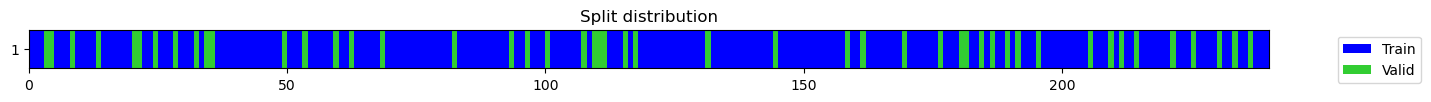

alpha: 1.00E+02  train: 0.92188  valid: 0.68750
[[145.  33.  48.  14.]
 [ 28. 179.  24.   9.]
 [ 40.  27. 152.  21.]
 [ 30.  13.  19. 178.]]
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components


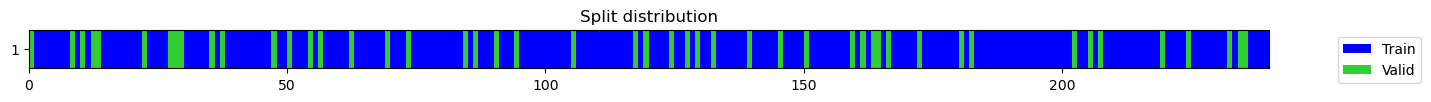

alpha: 1.00E+01  train: 1.00000  valid: 0.66667
[[8. 0. 3. 1.]
 [4. 7. 1. 0.]
 [0. 0. 9. 3.]
 [1. 1. 2. 8.]]


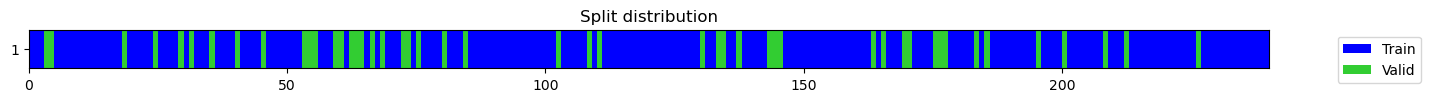

alpha: 1.00E+02  train: 0.92708  valid: 0.64583
[[14.  0.  9.  1.]
 [ 5. 13.  5.  1.]
 [ 0.  2. 18.  4.]
 [ 2.  1.  3. 18.]]


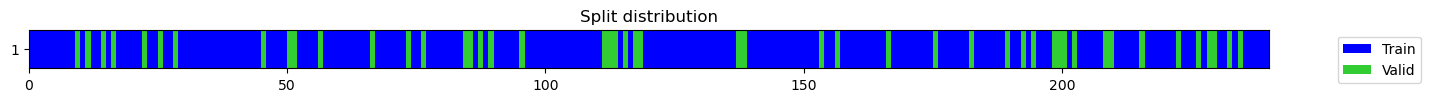

alpha: 1.00E+02  train: 0.93229  valid: 0.72917
[[21.  2. 11.  2.]
 [ 7. 23.  5.  1.]
 [ 2.  2. 27.  5.]
 [ 3.  2.  4. 27.]]


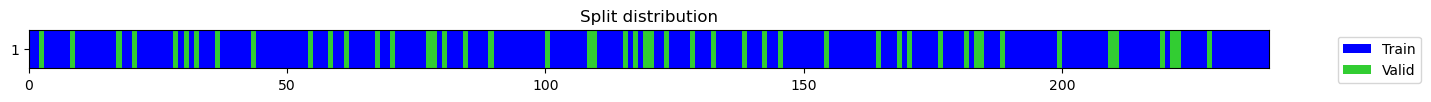

alpha: 1.00E+02  train: 0.93229  valid: 0.70833
[[30.  3. 13.  2.]
 [ 8. 31.  6.  3.]
 [ 3.  2. 38.  5.]
 [ 6.  3.  6. 33.]]


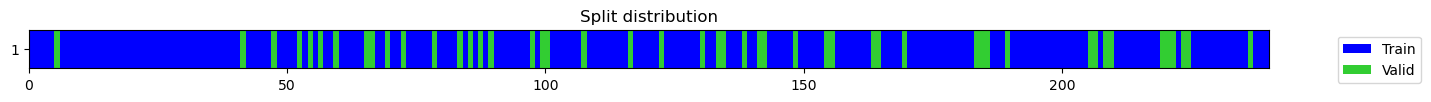

alpha: 1.00E+02  train: 0.93229  valid: 0.68750
[[38.  6. 14.  2.]
 [11. 38.  6.  5.]
 [ 4.  3. 46.  7.]
 [ 7.  3.  7. 43.]]


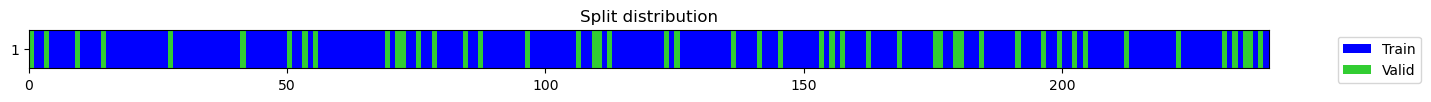

alpha: 1.00E+02  train: 0.94271  valid: 0.64583
[[47.  6. 17.  2.]
 [12. 46.  9.  5.]
 [ 9.  3. 53.  7.]
 [10.  3.  9. 50.]]


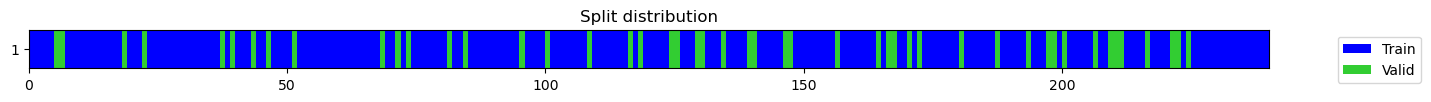

alpha: 1.00E+02  train: 0.93750  valid: 0.72917
[[55.  8. 18.  3.]
 [13. 54. 11.  6.]
 [11.  3. 61.  9.]
 [10.  3. 10. 61.]]


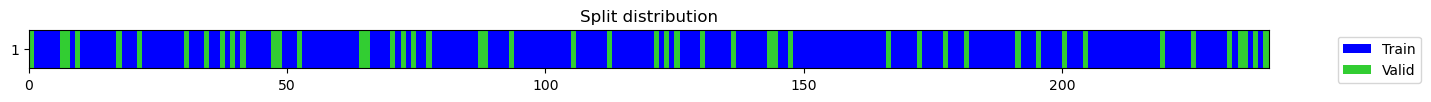

alpha: 1.00E+02  train: 0.94271  valid: 0.77083
[[62.  9. 22.  3.]
 [15. 64. 11.  6.]
 [11.  3. 71. 11.]
 [12.  3. 10. 71.]]


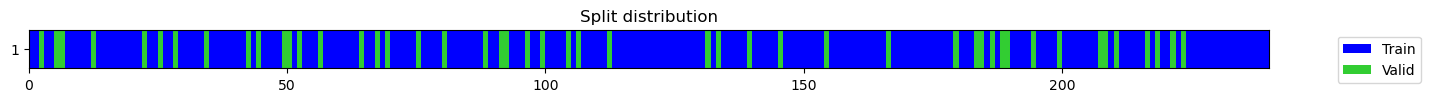

alpha: 1.00E+02  train: 0.94792  valid: 0.68750
[[72. 10. 23.  3.]
 [15. 73. 13.  7.]
 [15.  3. 77. 13.]
 [16.  3. 10. 79.]]


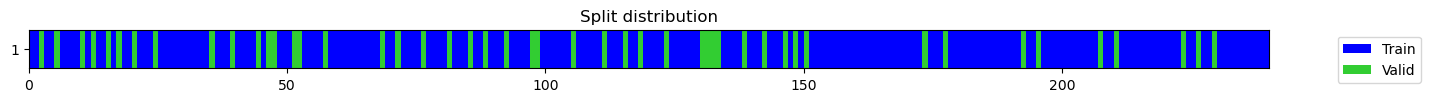

alpha: 1.00E+02  train: 0.94271  valid: 0.77083
[[81. 10. 25.  4.]
 [15. 81. 15.  9.]
 [17.  3. 87. 13.]
 [16.  4. 11. 89.]]


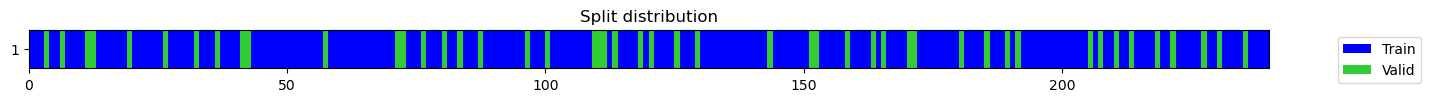

alpha: 1.00E+01  train: 1.00000  valid: 0.60417
[[90. 11. 26.  5.]
 [17. 87. 17. 11.]
 [22.  3. 93. 14.]
 [19.  4. 12. 97.]]


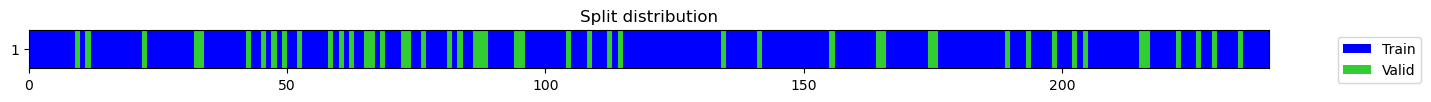

alpha: 1.00E+02  train: 0.93750  valid: 0.75000
[[101.  11.  27.   5.]
 [ 18.  96.  19.  11.]
 [ 27.   5.  97.  15.]
 [ 19.   4.  12. 109.]]


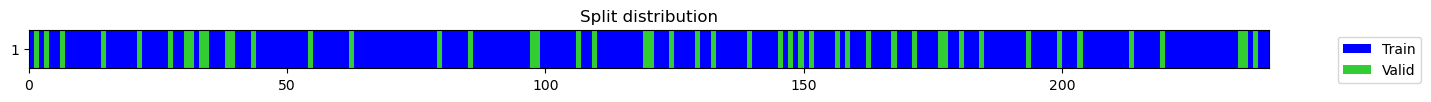

alpha: 1.00E+02  train: 0.91667  valid: 0.75000
[[109.  12.  28.   7.]
 [ 21. 104.  20.  11.]
 [ 29.   6. 106.  15.]
 [ 20.   4.  12. 120.]]


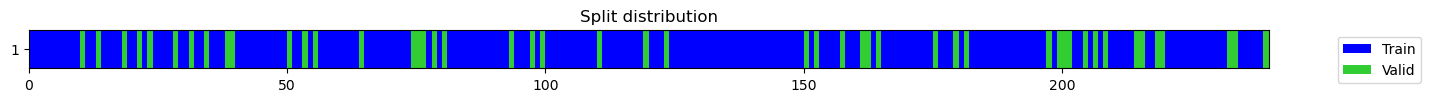

alpha: 1.00E+02  train: 0.92708  valid: 0.72917
[[118.  13.  28.   9.]
 [ 22. 112.  23.  11.]
 [ 32.   6. 115.  15.]
 [ 22.   4.  13. 129.]]


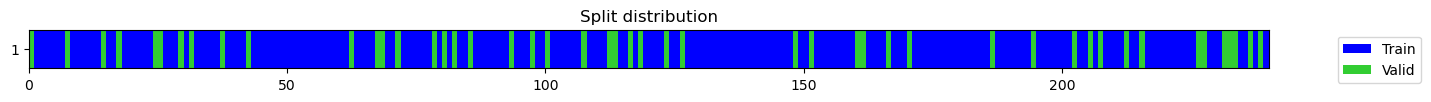

alpha: 1.00E+02  train: 0.91667  valid: 0.85417
[[127.  13.  29.  11.]
 [ 22. 124.  23.  11.]
 [ 35.   6. 124.  15.]
 [ 23.   4.  13. 140.]]


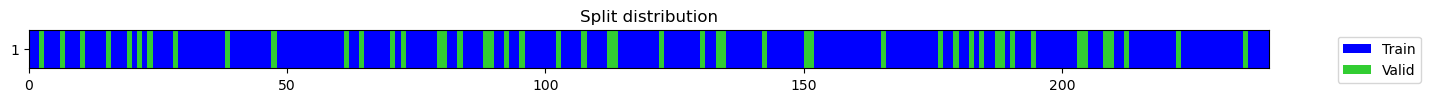

alpha: 1.00E+02  train: 0.91667  valid: 0.77083
[[136.  14.  30.  12.]
 [ 23. 133.  25.  11.]
 [ 36.   6. 134.  16.]
 [ 23.   6.  14. 149.]]


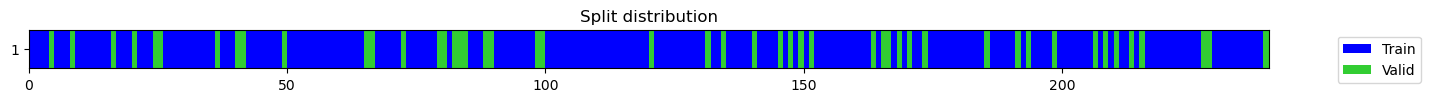

alpha: 1.00E+02  train: 0.93750  valid: 0.58333
[[140.  17.  34.  13.]
 [ 25. 143.  25.  11.]
 [ 39.   6. 141.  18.]
 [ 28.   6.  14. 156.]]


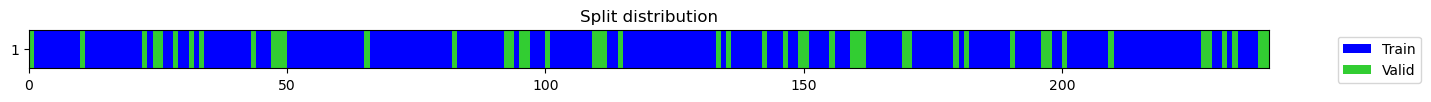

alpha: 1.00E+01  train: 1.00000  valid: 0.75000
[[147.  19.  36.  14.]
 [ 27. 153.  25.  11.]
 [ 40.   6. 152.  18.]
 [ 30.   7.  15. 164.]]


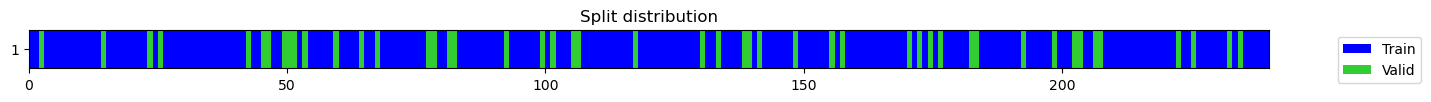

alpha: 1.00E+02  train: 0.92188  valid: 0.70833
[[155.  21.  37.  15.]
 [ 27. 163.  27.  11.]
 [ 42.   7. 161.  18.]
 [ 33.   8.  16. 171.]]


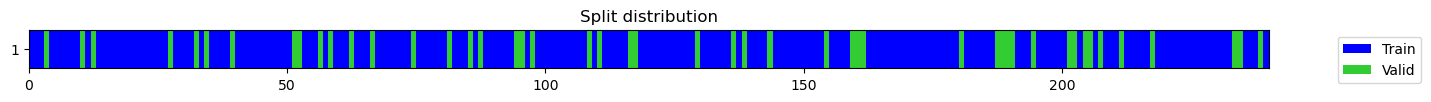

alpha: 1.00E+02  train: 0.92708  valid: 0.68750
[[160.  23.  40.  17.]
 [ 30. 171.  27.  12.]
 [ 43.   8. 170.  19.]
 [ 33.   9.  16. 182.]]
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components


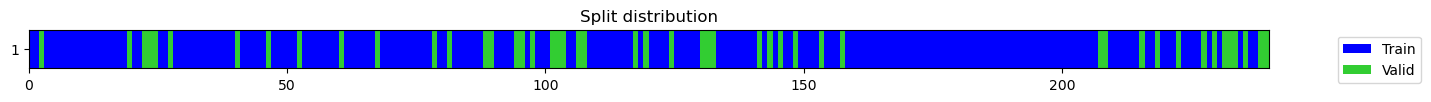

alpha: 1.00E+02  train: 0.92708  valid: 0.68750
[[ 9.  2.  0.  1.]
 [ 1.  9.  2.  0.]
 [ 5.  2.  5.  0.]
 [ 1.  1.  0. 10.]]


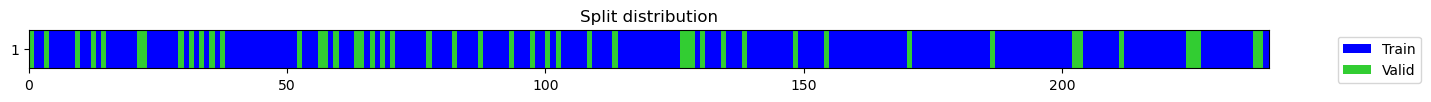

alpha: 1.00E+02  train: 0.94271  valid: 0.64583
[[17.  5.  0.  2.]
 [ 4. 17.  2.  1.]
 [ 8.  4. 11.  1.]
 [ 3.  1.  1. 19.]]


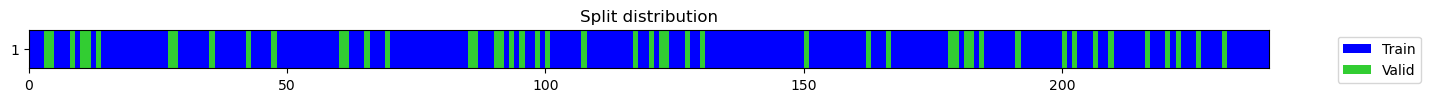

alpha: 1.00E+02  train: 0.93229  valid: 0.75000
[[25.  6.  3.  2.]
 [ 4. 28.  3.  1.]
 [ 8.  4. 21.  3.]
 [ 5.  1.  4. 26.]]


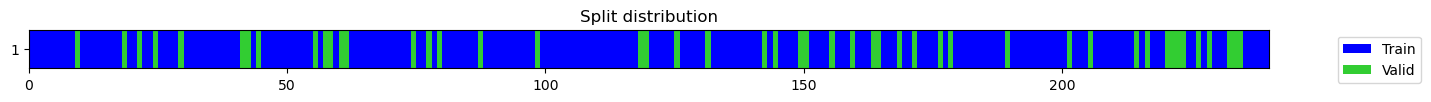

alpha: 1.00E+02  train: 0.93229  valid: 0.66667
[[33.  8.  3.  4.]
 [ 7. 36.  4.  1.]
 [11.  4. 27.  6.]
 [ 5.  1.  6. 36.]]


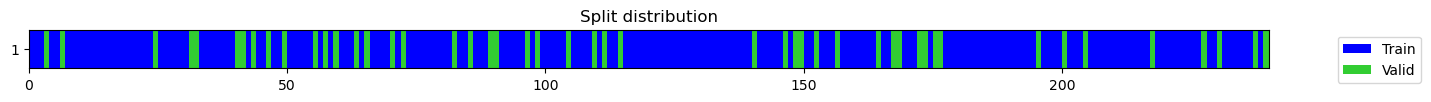

alpha: 1.00E+02  train: 0.91146  valid: 0.81250
[[43.  8.  4.  5.]
 [ 7. 48.  4.  1.]
 [13.  5. 35.  7.]
 [ 8.  1.  6. 45.]]


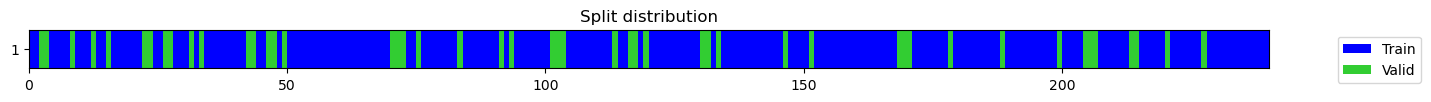

alpha: 1.00E+02  train: 0.92188  valid: 0.83333
[[52.  8.  5.  7.]
 [ 7. 60.  4.  1.]
 [15.  6. 43.  8.]
 [ 9.  1.  6. 56.]]


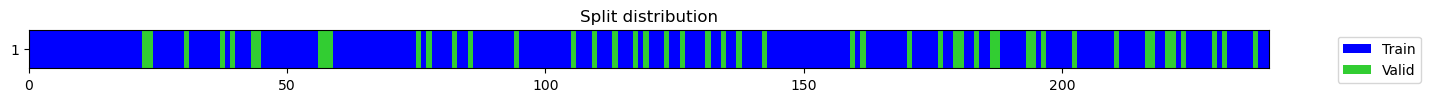

alpha: 1.00E+02  train: 0.93750  valid: 0.72917
[[60.  9.  8.  7.]
 [ 8. 70.  5.  1.]
 [19.  7. 49.  9.]
 [10.  1.  6. 67.]]


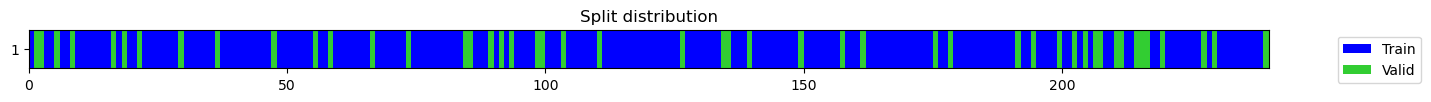

alpha: 1.00E+02  train: 0.92188  valid: 0.68750
[[71. 10.  8.  7.]
 [10. 77.  7.  2.]
 [21.  9. 57.  9.]
 [11.  2.  9. 74.]]


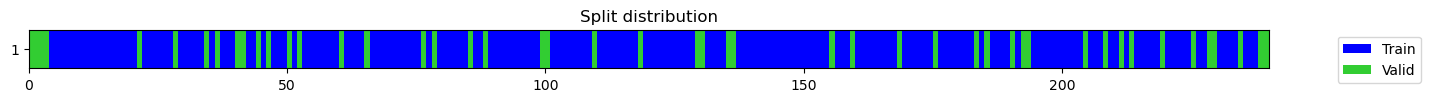

alpha: 1.00E+02  train: 0.90625  valid: 0.79167
[[81. 12.  8.  7.]
 [10. 88.  8.  2.]
 [23. 12. 63. 10.]
 [12.  2.  9. 85.]]


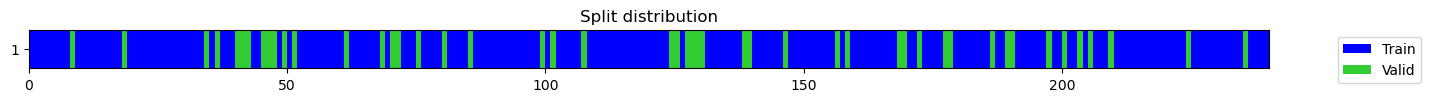

alpha: 1.00E+02  train: 0.92708  valid: 0.66667
[[89. 13.  9.  9.]
 [10. 96. 11.  3.]
 [26. 12. 69. 13.]
 [14.  2.  9. 95.]]


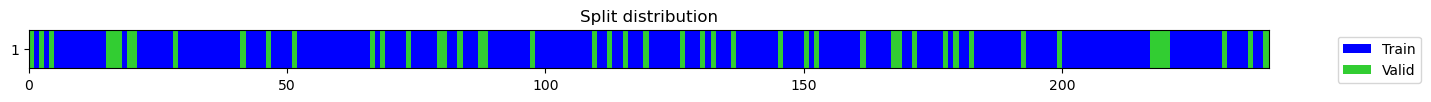

alpha: 1.00E+02  train: 0.93750  valid: 0.72917
[[ 97.  15.  10.  10.]
 [ 11. 106.  11.   4.]
 [ 27.  13.  76.  16.]
 [ 14.   3.  10. 105.]]


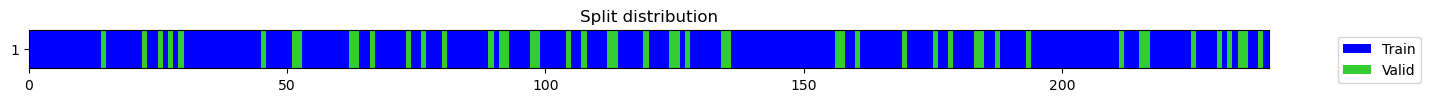

alpha: 1.00E+02  train: 0.92188  valid: 0.66667
[[106.  16.  12.  10.]
 [ 16. 112.  11.   5.]
 [ 30.  13.  83.  18.]
 [ 15.   3.  11. 115.]]


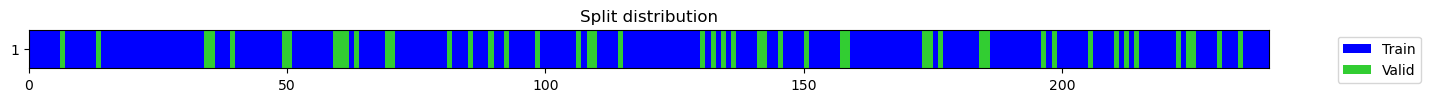

alpha: 1.00E+02  train: 0.92708  valid: 0.72917
[[116.  18.  12.  10.]
 [ 17. 120.  12.   7.]
 [ 32.  13.  90.  21.]
 [ 17.   3.  11. 125.]]


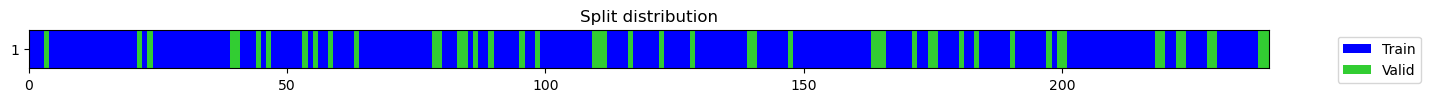

alpha: 1.00E+02  train: 0.92188  valid: 0.79167
[[121.  20.  14.  13.]
 [ 17. 132.  12.   7.]
 [ 32.  13. 100.  23.]
 [ 18.   3.  11. 136.]]


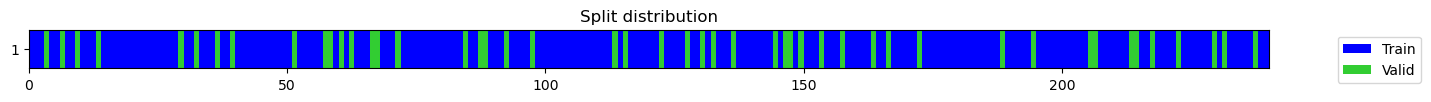

alpha: 1.00E+02  train: 0.91667  valid: 0.79167
[[131.  21.  14.  14.]
 [ 18. 141.  12.   9.]
 [ 33.  13. 108.  26.]
 [ 19.   3.  11. 147.]]


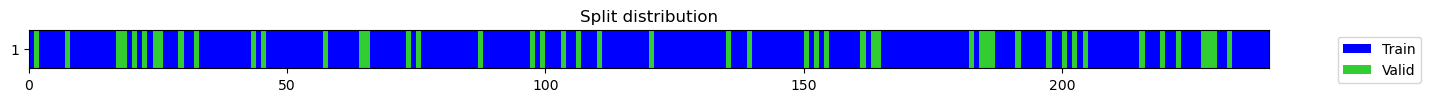

alpha: 1.00E+02  train: 0.94271  valid: 0.70833
[[140.  22.  16.  14.]
 [ 20. 149.  14.   9.]
 [ 34.  15. 115.  28.]
 [ 21.   3.  11. 157.]]


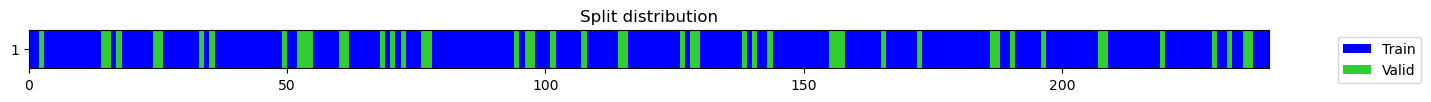

alpha: 1.00E+02  train: 0.91667  valid: 0.66667
[[148.  25.  17.  14.]
 [ 20. 158.  17.   9.]
 [ 35.  16. 124.  29.]
 [ 23.   5.  13. 163.]]


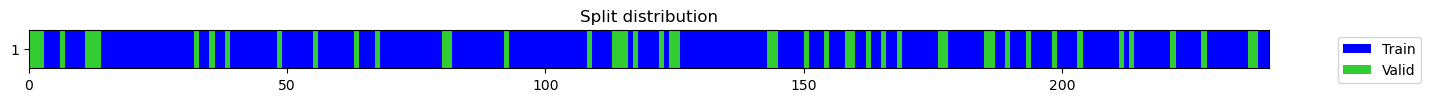

alpha: 1.00E+02  train: 0.93229  valid: 0.62500
[[153.  27.  21.  15.]
 [ 23. 165.  18.  10.]
 [ 36.  18. 133.  29.]
 [ 25.   6.  13. 172.]]


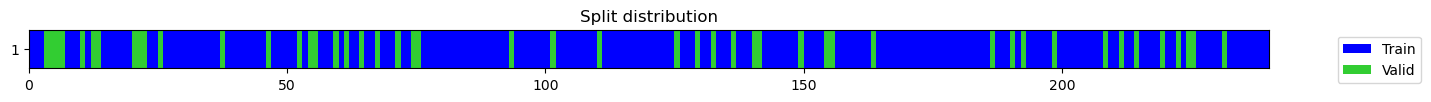

alpha: 1.00E+02  train: 0.92708  valid: 0.60417
[[161.  29.  23.  15.]
 [ 25. 172.  21.  10.]
 [ 38.  21. 139.  30.]
 [ 28.   6.  14. 180.]]


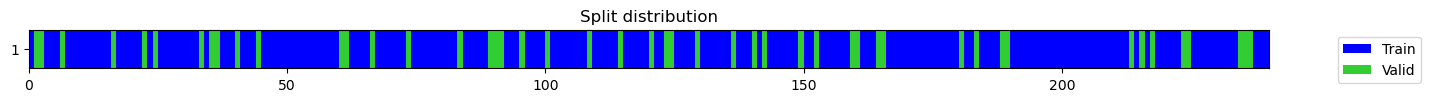

alpha: 1.00E+02  train: 0.93750  valid: 0.68750
[[170.  29.  25.  16.]
 [ 27. 180.  22.  11.]
 [ 40.  22. 147.  31.]
 [ 29.   8.  15. 188.]]
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components


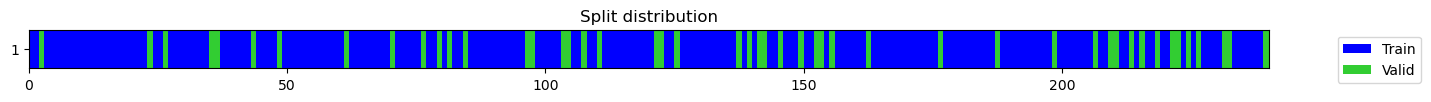

alpha: 1.00E+02  train: 0.93229  valid: 0.72917
[[11.  1.  0.  0.]
 [ 0. 10.  2.  0.]
 [ 3.  3.  5.  1.]
 [ 0.  3.  0.  9.]]


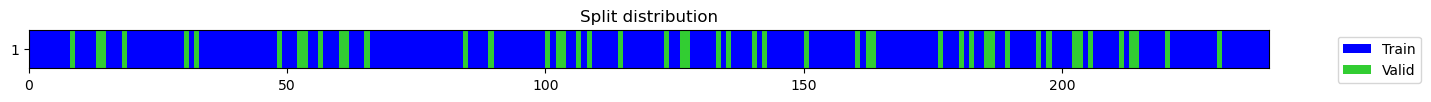

alpha: 1.00E+02  train: 0.94271  valid: 0.81250
[[19.  2.  3.  0.]
 [ 1. 21.  2.  0.]
 [ 5.  3. 15.  1.]
 [ 2.  3.  0. 19.]]


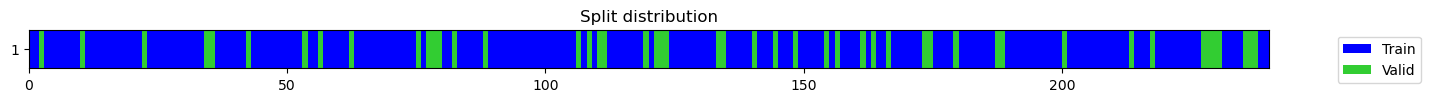

alpha: 1.00E+01  train: 1.00000  valid: 0.62500
[[27.  4.  5.  0.]
 [ 3. 29.  2.  2.]
 [ 7.  4. 24.  1.]
 [ 5.  3.  4. 24.]]


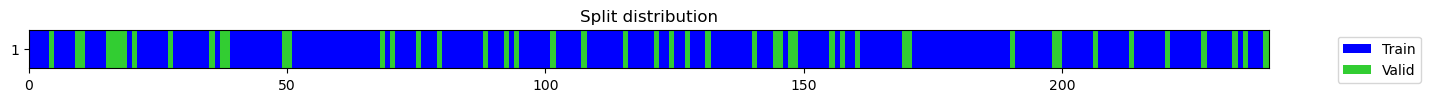

alpha: 1.00E+02  train: 0.92708  valid: 0.64583
[[32.  6.  8.  2.]
 [ 5. 39.  2.  2.]
 [ 9.  6. 30.  3.]
 [ 6.  3.  5. 34.]]


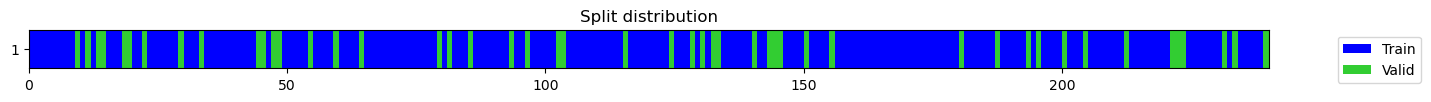

alpha: 1.00E+02  train: 0.94792  valid: 0.68750
[[41.  8.  9.  2.]
 [ 5. 48.  5.  2.]
 [11.  7. 38.  4.]
 [ 8.  5.  6. 41.]]


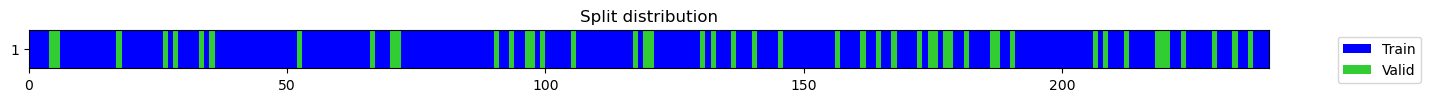

alpha: 1.00E+02  train: 0.94271  valid: 0.75000
[[47. 11. 12.  2.]
 [ 5. 58.  6.  3.]
 [12.  8. 47.  5.]
 [ 8.  6.  6. 52.]]


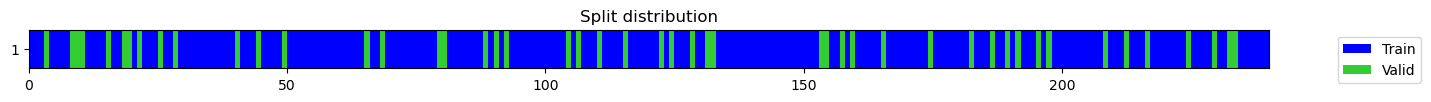

alpha: 1.00E+02  train: 0.93229  valid: 0.70833
[[55. 12. 15.  2.]
 [ 7. 67.  7.  3.]
 [15.  8. 54.  7.]
 [ 8.  8.  6. 62.]]


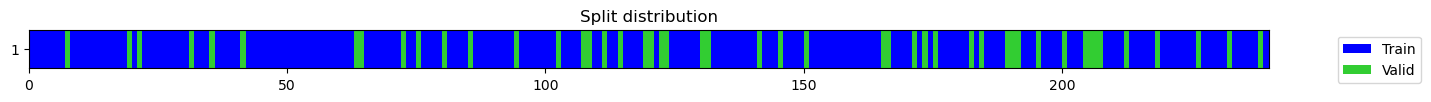

alpha: 1.00E+01  train: 1.00000  valid: 0.62500
[[62. 15. 17.  2.]
 [ 8. 76.  9.  3.]
 [18.  8. 59. 11.]
 [10.  8.  7. 71.]]


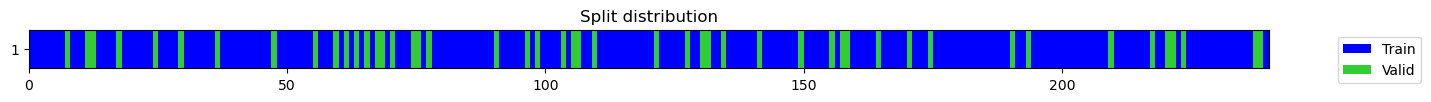

alpha: 1.00E+01  train: 1.00000  valid: 0.64583
[[67. 16. 19.  6.]
 [10. 83. 11.  4.]
 [19.  9. 67. 13.]
 [10.  8.  8. 82.]]


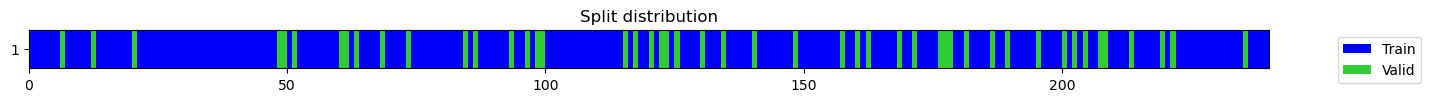

alpha: 1.00E+02  train: 0.92188  valid: 0.70833
[[75. 18. 20.  7.]
 [12. 90. 14.  4.]
 [20.  9. 77. 14.]
 [12.  9.  8. 91.]]


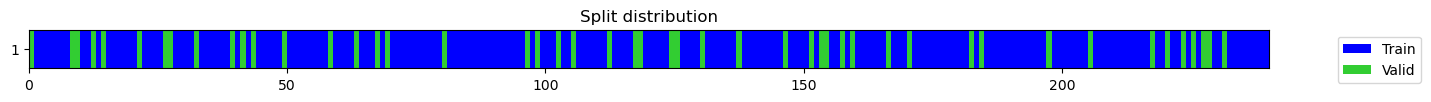

alpha: 1.00E+02  train: 0.92188  valid: 0.81250
[[ 82.  20.  22.   8.]
 [ 13. 100.  15.   4.]
 [ 21.  10.  87.  14.]
 [ 12.   9.   8. 103.]]


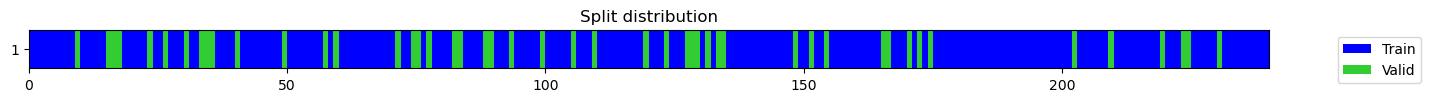

alpha: 1.00E+01  train: 1.00000  valid: 0.64583
[[ 90.  21.  24.   9.]
 [ 17. 106.  17.   4.]
 [ 25.  10.  94.  15.]
 [ 12.  10.   9. 113.]]


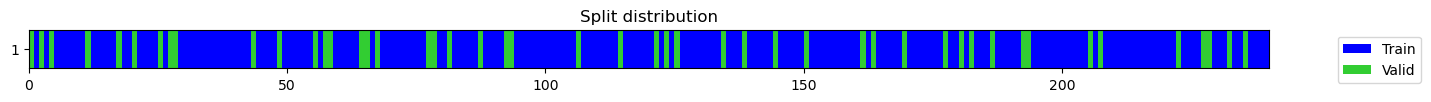

alpha: 1.00E+02  train: 0.93750  valid: 0.66667
[[ 99.  22.  26.   9.]
 [ 20. 112.  20.   4.]
 [ 28.  10. 102.  16.]
 [ 14.  11.   9. 122.]]


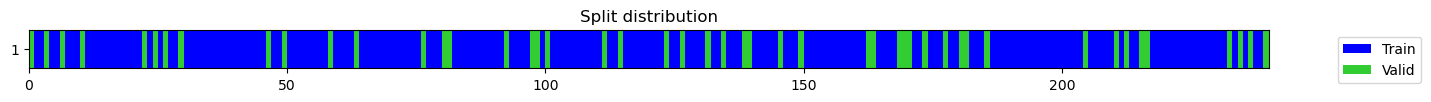

alpha: 1.00E+02  train: 0.92188  valid: 0.62500
[[105.  22.  31.  10.]
 [ 24. 119.  20.   5.]
 [ 29.  11. 111.  17.]
 [ 16.  12.  10. 130.]]


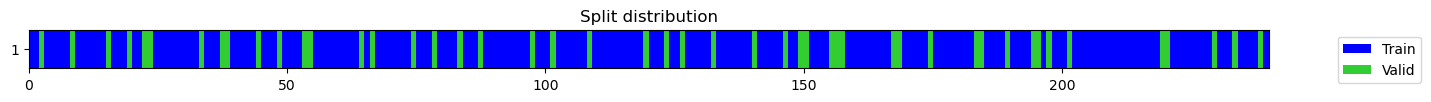

alpha: 1.00E+01  train: 0.99479  valid: 0.72917
[[115.  24.  31.  10.]
 [ 26. 128.  21.   5.]
 [ 34.  12. 117.  17.]
 [ 18.  12.  10. 140.]]


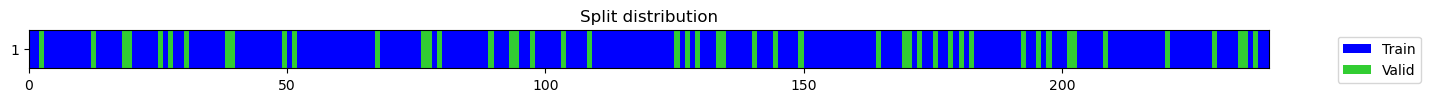

alpha: 1.00E+02  train: 0.92708  valid: 0.72917
[[122.  26.  31.  13.]
 [ 28. 138.  21.   5.]
 [ 35.  13. 124.  20.]
 [ 18.  12.  11. 151.]]


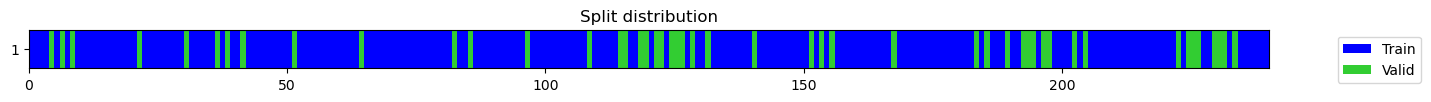

alpha: 1.00E+02  train: 0.93750  valid: 0.72917
[[131.  28.  32.  13.]
 [ 29. 146.  23.   6.]
 [ 35.  15. 133.  21.]
 [ 19.  13.  12. 160.]]


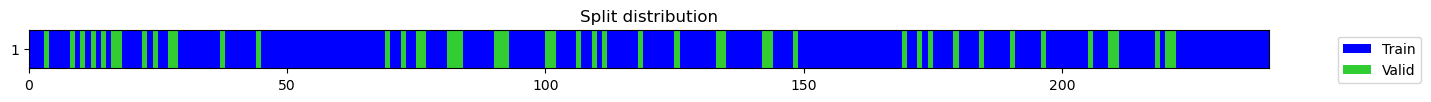

alpha: 1.00E+02  train: 0.93229  valid: 0.83333
[[140.  29.  32.  15.]
 [ 29. 156.  24.   7.]
 [ 35.  16. 143.  22.]
 [ 20.  13.  12. 171.]]


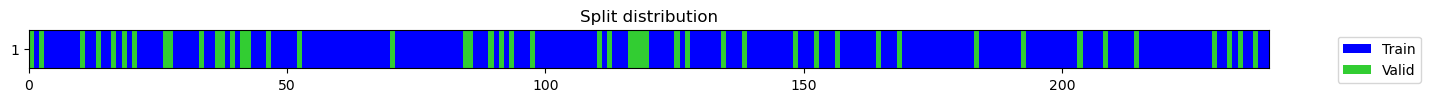

alpha: 1.00E+02  train: 0.93229  valid: 0.83333
[[150.  29.  34.  15.]
 [ 29. 167.  25.   7.]
 [ 37.  17. 152.  22.]
 [ 21.  14.  12. 181.]]


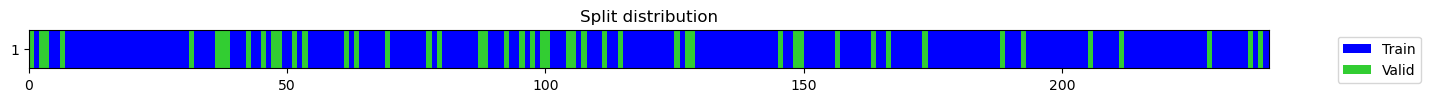

alpha: 1.00E+02  train: 0.94792  valid: 0.72917
[[159.  29.  36.  16.]
 [ 30. 177.  26.   7.]
 [ 41.  18. 159.  22.]
 [ 23.  14.  13. 190.]]
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components


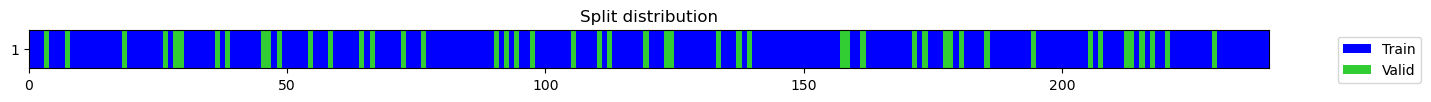

alpha: 1.00E+02  train: 0.92188  valid: 0.68750
[[9. 0. 1. 2.]
 [3. 8. 0. 1.]
 [1. 1. 9. 1.]
 [3. 0. 2. 7.]]


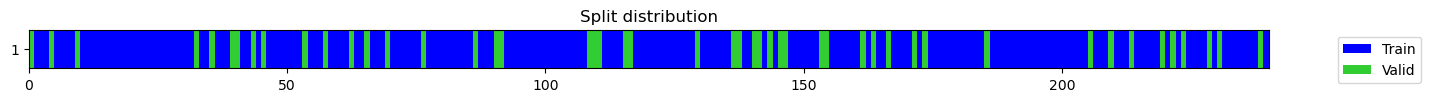

alpha: 1.00E+02  train: 0.91667  valid: 0.72917
[[18.  2.  1.  3.]
 [ 6. 16.  1.  1.]
 [ 3.  3. 17.  1.]
 [ 5.  0.  2. 17.]]


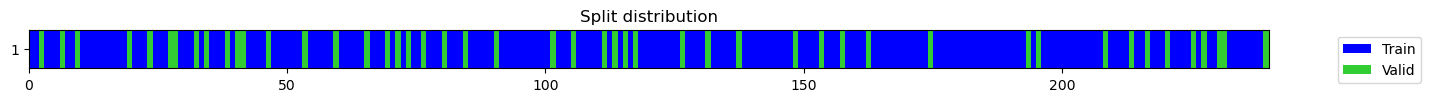

alpha: 1.00E+02  train: 0.92708  valid: 0.58333
[[23.  5.  3.  5.]
 [ 7. 23.  4.  2.]
 [ 4.  6. 24.  2.]
 [ 6.  0.  4. 26.]]


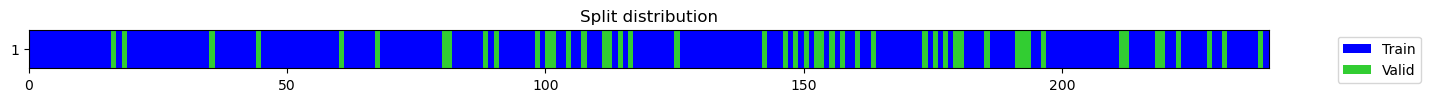

alpha: 1.00E+02  train: 0.92708  valid: 0.68750
[[31.  7.  4.  6.]
 [11. 30.  5.  2.]
 [ 7.  6. 31.  4.]
 [ 7.  0.  4. 37.]]


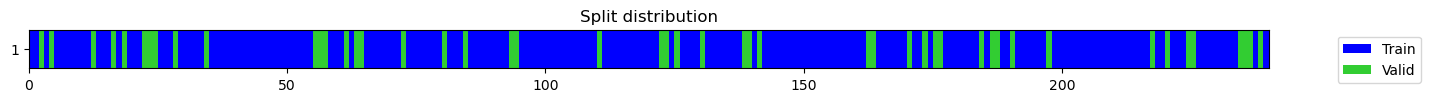

alpha: 1.00E+02  train: 0.93229  valid: 0.68750
[[40.  9.  5.  6.]
 [12. 40.  6.  2.]
 [10.  7. 39.  4.]
 [ 9.  1.  7. 43.]]


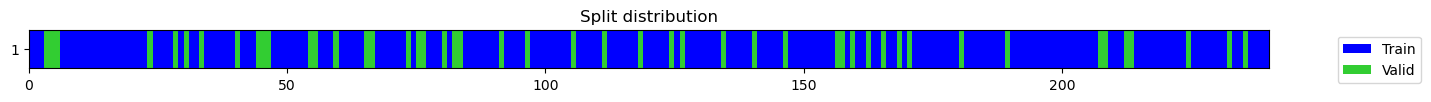

alpha: 1.00E+01  train: 1.00000  valid: 0.60417
[[45. 10.  8.  9.]
 [12. 49.  9.  2.]
 [12. 10. 45.  5.]
 [12.  1.  7. 52.]]


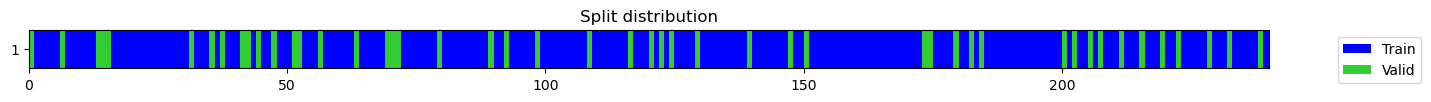

alpha: 1.00E+02  train: 0.93750  valid: 0.81250
[[52. 12. 11.  9.]
 [12. 60. 10.  2.]
 [13. 10. 55.  6.]
 [13.  1.  7. 63.]]


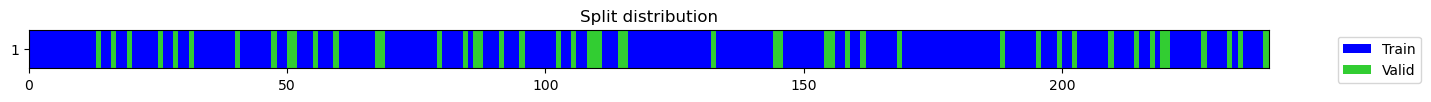

alpha: 1.00E+02  train: 0.93229  valid: 0.75000
[[59. 15. 12. 10.]
 [12. 70. 11.  3.]
 [14. 10. 66.  6.]
 [14.  3.  8. 71.]]


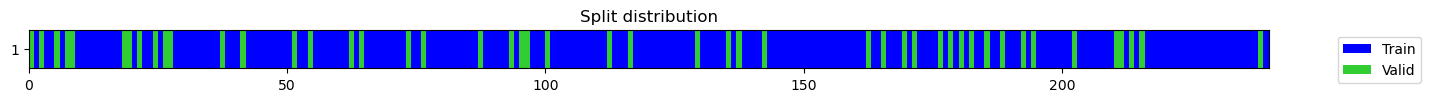

alpha: 1.00E+02  train: 0.95312  valid: 0.72917
[[67. 17. 14. 10.]
 [14. 80. 11.  3.]
 [15. 12. 74.  7.]
 [17.  3.  8. 80.]]


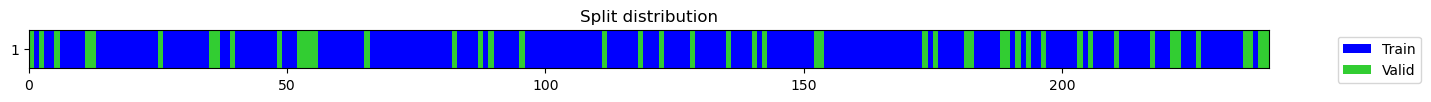

alpha: 1.00E+02  train: 0.94792  valid: 0.66667
[[74. 19. 15. 12.]
 [16. 89. 12.  3.]
 [17. 13. 82.  8.]
 [20.  3.  9. 88.]]


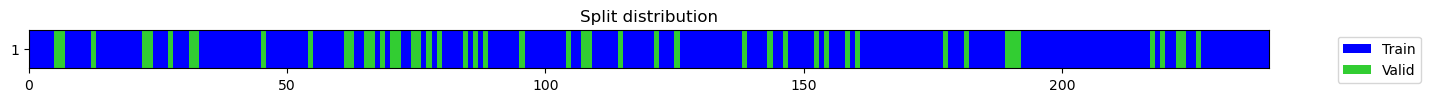

alpha: 1.00E+02  train: 0.92188  valid: 0.77083
[[84. 20. 16. 12.]
 [16. 99. 14.  3.]
 [22. 13. 89.  8.]
 [22.  3.  9. 98.]]


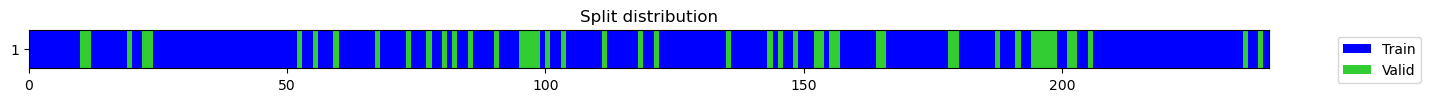

alpha: 1.00E+02  train: 0.93229  valid: 0.70833
[[ 91.  22.  17.  14.]
 [ 17. 108.  14.   5.]
 [ 24.  13.  97.  10.]
 [ 23.   4.   9. 108.]]


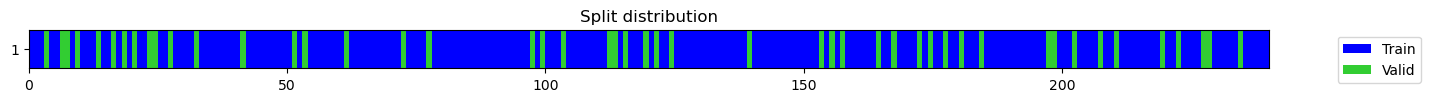

alpha: 1.00E+01  train: 0.99479  valid: 0.62500
[[ 99.  23.  19.  15.]
 [ 21. 114.  16.   5.]
 [ 24.  14. 104.  14.]
 [ 24.   5.  10. 117.]]


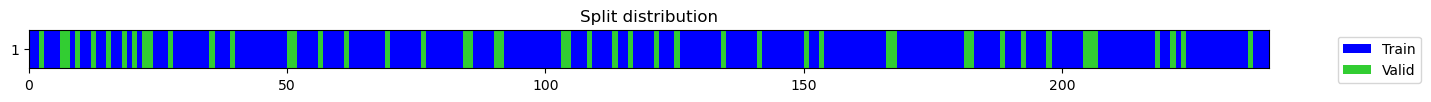

alpha: 1.00E+02  train: 0.93229  valid: 0.56250
[[104.  25.  24.  15.]
 [ 23. 120.  19.   6.]
 [ 26.  16. 112.  14.]
 [ 25.   5.  13. 125.]]


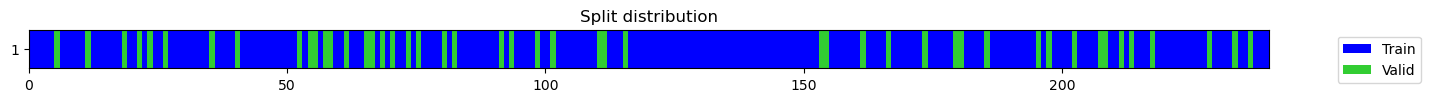

alpha: 1.00E+01  train: 0.99479  valid: 0.60417
[[112.  26.  26.  16.]
 [ 25. 127.  21.   7.]
 [ 28.  18. 119.  15.]
 [ 27.   5.  16. 132.]]


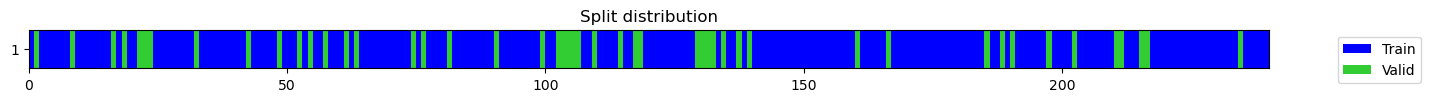

alpha: 1.00E+02  train: 0.94271  valid: 0.66667
[[119.  27.  28.  18.]
 [ 27. 136.  22.   7.]
 [ 29.  19. 127.  17.]
 [ 29.   5.  18. 140.]]


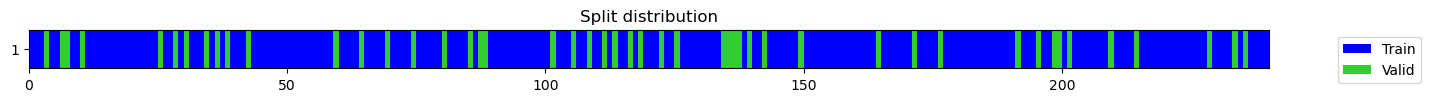

alpha: 1.00E+01  train: 1.00000  valid: 0.64583
[[127.  28.  31.  18.]
 [ 30. 143.  23.   8.]
 [ 31.  20. 135.  18.]
 [ 30.   5.  21. 148.]]


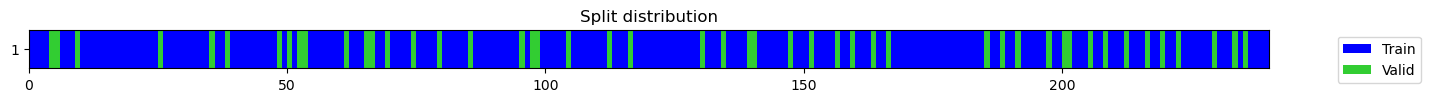

alpha: 1.00E+02  train: 0.92708  valid: 0.81250
[[137.  29.  32.  18.]
 [ 31. 153.  23.   9.]
 [ 31.  22. 144.  19.]
 [ 31.   6.  21. 158.]]


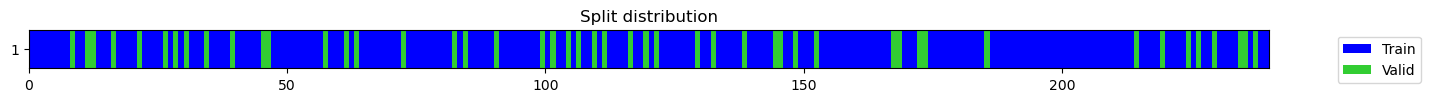

alpha: 1.00E+02  train: 0.94271  valid: 0.75000
[[143.  31.  35.  19.]
 [ 32. 161.  26.   9.]
 [ 31.  23. 155.  19.]
 [ 31.   6.  22. 169.]]


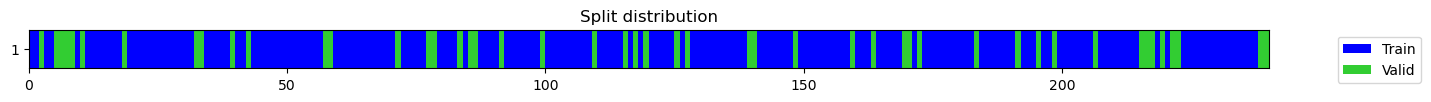

alpha: 1.00E+02  train: 0.92708  valid: 0.79167
[[152.  31.  36.  21.]
 [ 34. 169.  28.   9.]
 [ 31.  24. 164.  21.]
 [ 31.   6.  22. 181.]]
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components


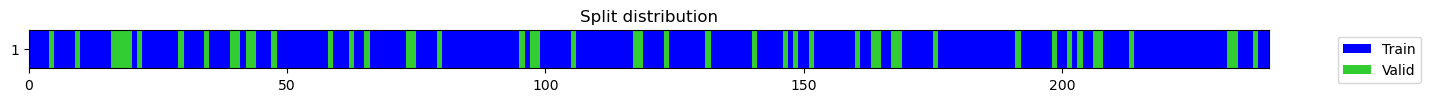

alpha: 1.00E+02  train: 0.91667  valid: 0.68750
[[8. 2. 2. 0.]
 [1. 9. 2. 0.]
 [3. 1. 7. 1.]
 [1. 1. 1. 9.]]


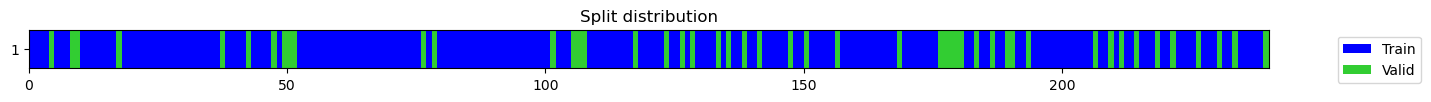

alpha: 1.00E+02  train: 0.92708  valid: 0.77083
[[17.  2.  3.  2.]
 [ 3. 17.  4.  0.]
 [ 4.  2. 17.  1.]
 [ 3.  1.  1. 19.]]


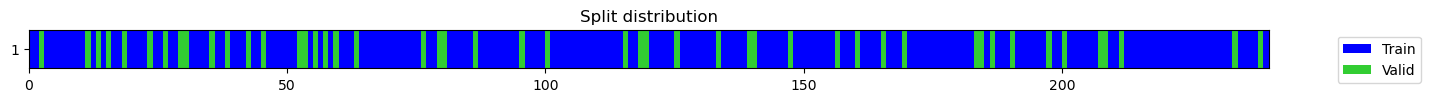

alpha: 1.00E+02  train: 0.91667  valid: 0.72917
[[26.  4.  3.  3.]
 [ 4. 28.  4.  0.]
 [ 7.  3. 25.  1.]
 [ 6.  3.  1. 26.]]


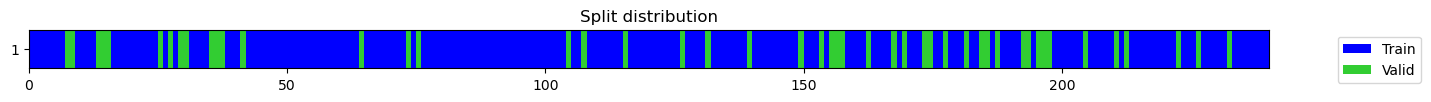

alpha: 1.00E+01  train: 1.00000  valid: 0.58333
[[33.  5.  5.  5.]
 [ 8. 35.  5.  0.]
 [ 9.  7. 30.  2.]
 [ 8.  4.  1. 35.]]


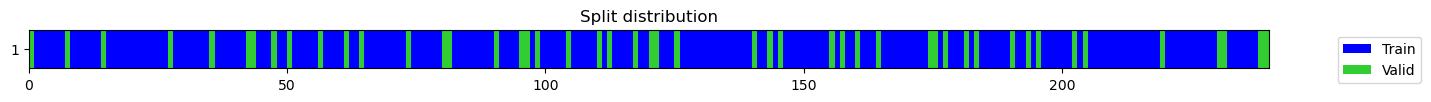

alpha: 1.00E+02  train: 0.93750  valid: 0.70833
[[41.  6.  8.  5.]
 [10. 44.  6.  0.]
 [13.  8. 37.  2.]
 [ 8.  4.  3. 45.]]


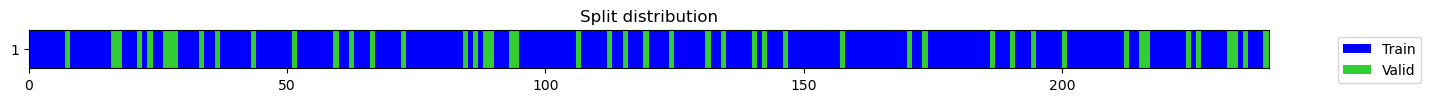

alpha: 1.00E+02  train: 0.92708  valid: 0.72917
[[47.  8. 10.  7.]
 [11. 53.  7.  1.]
 [13.  8. 48.  3.]
 [ 9.  5.  4. 54.]]


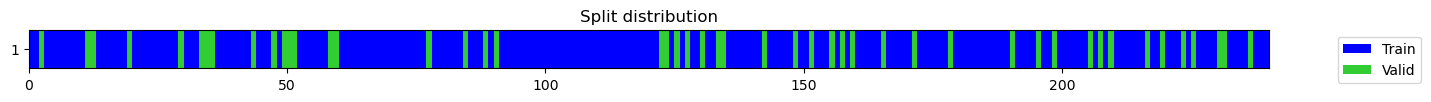

alpha: 1.00E+02  train: 0.93750  valid: 0.64583
[[56.  8. 12.  8.]
 [15. 58. 10.  1.]
 [14.  9. 56.  5.]
 [10.  6.  5. 63.]]


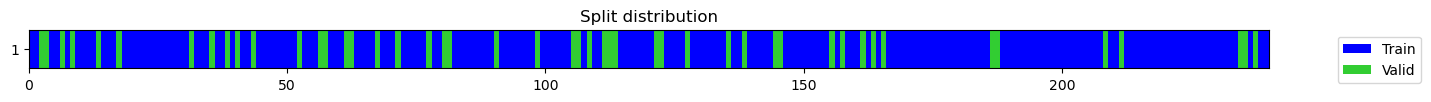

alpha: 1.00E+02  train: 0.92188  valid: 0.66667
[[62.  8. 16. 10.]
 [17. 68. 10.  1.]
 [16. 11. 63.  6.]
 [12.  6.  6. 72.]]


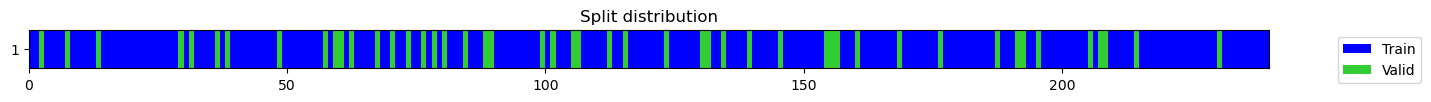

alpha: 1.00E+02  train: 0.92708  valid: 0.72917
[[69. 11. 17. 11.]
 [18. 78. 11.  1.]
 [18. 11. 72.  7.]
 [14.  6.  7. 81.]]


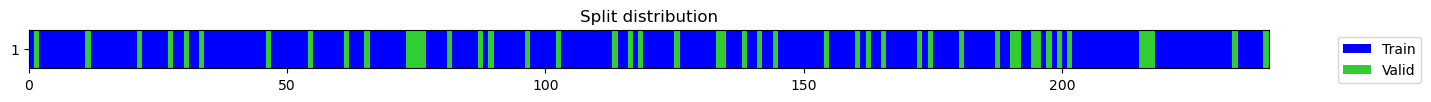

alpha: 1.00E+02  train: 0.95312  valid: 0.60417
[[75. 13. 21. 11.]
 [20. 86. 12.  2.]
 [18. 13. 78. 11.]
 [14.  6. 10. 90.]]


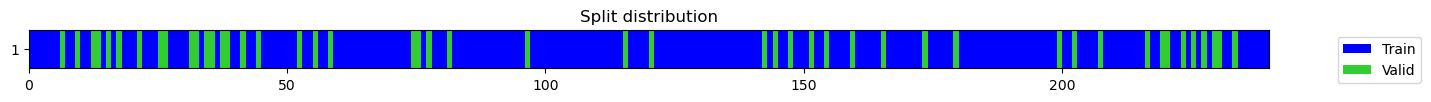

alpha: 1.00E+02  train: 0.93229  valid: 0.72917
[[85. 13. 23. 11.]
 [23. 94. 13.  2.]
 [20. 15. 86. 11.]
 [15.  6. 12. 99.]]


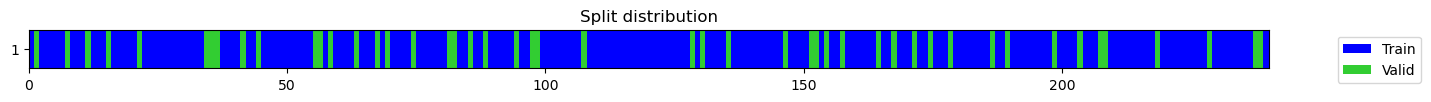

alpha: 1.00E+02  train: 0.92708  valid: 0.77083
[[ 92.  14.  26.  12.]
 [ 23. 105.  14.   2.]
 [ 22.  15.  96.  11.]
 [ 18.   6.  12. 108.]]


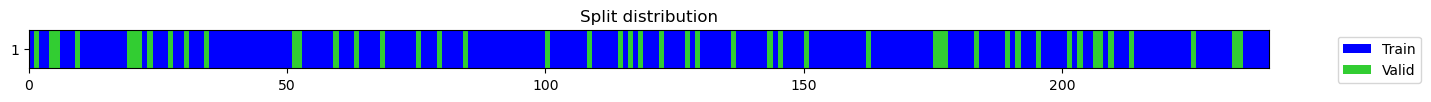

alpha: 1.00E+02  train: 0.94792  valid: 0.66667
[[101.  15.  28.  12.]
 [ 24. 114.  16.   2.]
 [ 26.  17. 102.  11.]
 [ 20.   7.  13. 116.]]


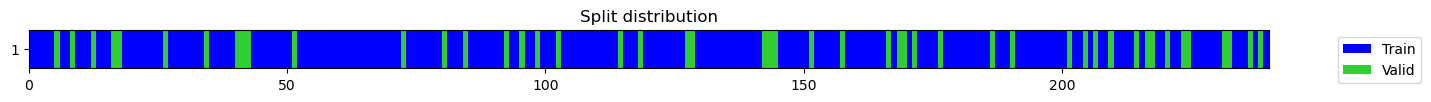

alpha: 1.00E+02  train: 0.92708  valid: 0.81250
[[110.  16.  30.  12.]
 [ 24. 124.  17.   3.]
 [ 28.  17. 111.  12.]
 [ 20.   8.  13. 127.]]


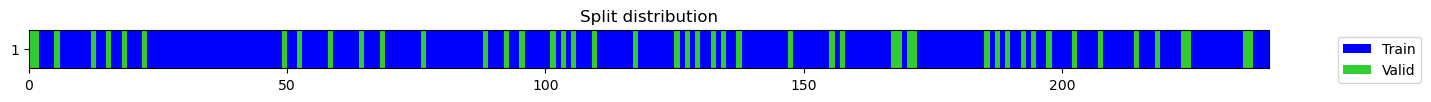

alpha: 1.00E+02  train: 0.93750  valid: 0.70833
[[119.  18.  30.  13.]
 [ 25. 132.  19.   4.]
 [ 32.  18. 117.  13.]
 [ 20.   9.  13. 138.]]


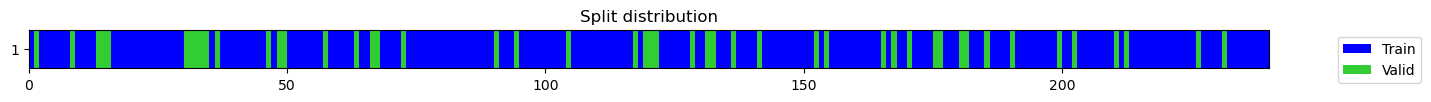

alpha: 1.00E+02  train: 0.92708  valid: 0.70833
[[128.  18.  32.  14.]
 [ 27. 140.  21.   4.]
 [ 36.  18. 125.  13.]
 [ 20.  11.  14. 147.]]


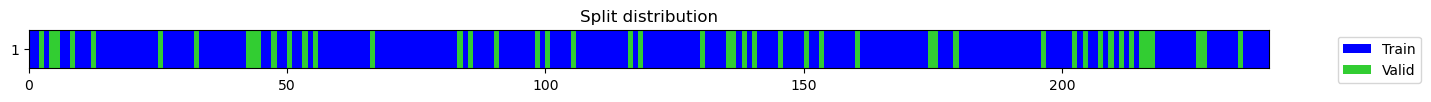

alpha: 1.00E+02  train: 0.94792  valid: 0.75000
[[138.  19.  32.  15.]
 [ 28. 149.  23.   4.]
 [ 37.  20. 132.  15.]
 [ 21.  12.  14. 157.]]


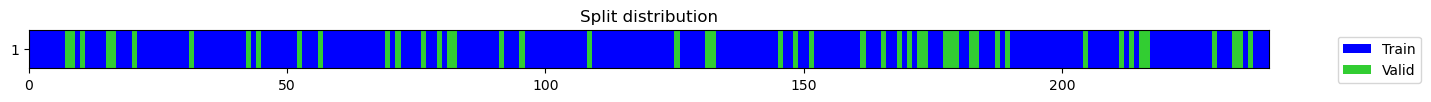

alpha: 1.00E+02  train: 0.94271  valid: 0.75000
[[148.  20.  32.  16.]
 [ 30. 159.  23.   4.]
 [ 40.  20. 140.  16.]
 [ 23.  14.  14. 165.]]


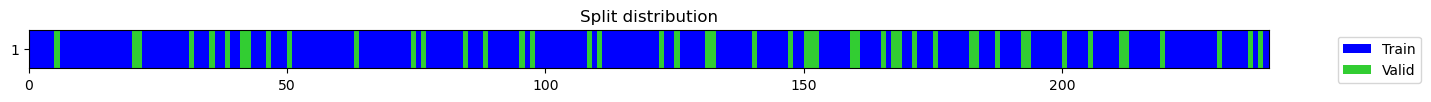

alpha: 1.00E+02  train: 0.94271  valid: 0.58333
[[154.  21.  37.  16.]
 [ 33. 165.  24.   6.]
 [ 42.  21. 147.  18.]
 [ 24.  14.  16. 174.]]


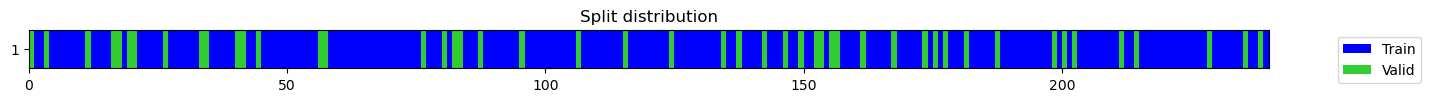

alpha: 1.00E+02  train: 0.93229  valid: 0.72917
[[164.  22.  38.  16.]
 [ 34. 174.  26.   6.]
 [ 45.  22. 155.  18.]
 [ 25.  16.  17. 182.]]
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components


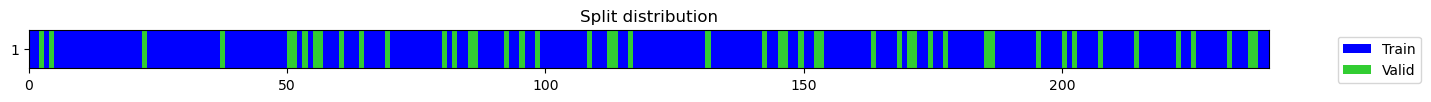

alpha: 1.00E+02  train: 0.93750  valid: 0.60417
[[ 6.  0.  4.  2.]
 [ 5.  6.  0.  1.]
 [ 1.  0. 11.  0.]
 [ 2.  1.  3.  6.]]


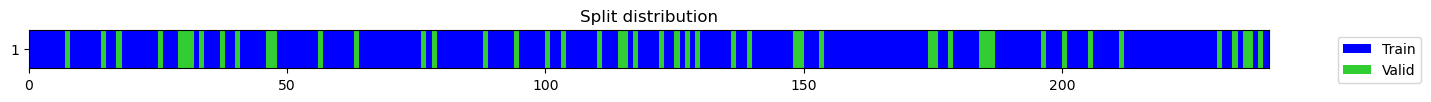

alpha: 1.00E+02  train: 0.91667  valid: 0.81250
[[14.  3.  4.  3.]
 [ 6. 16.  1.  1.]
 [ 3.  0. 21.  0.]
 [ 3.  1.  3. 17.]]


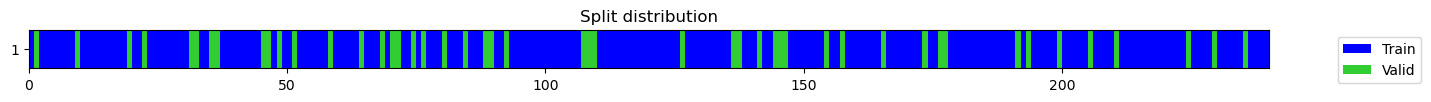

alpha: 1.00E+02  train: 0.92708  valid: 0.70833
[[23.  4.  5.  4.]
 [ 9. 23.  3.  1.]
 [ 6.  0. 29.  1.]
 [ 5.  1.  3. 27.]]


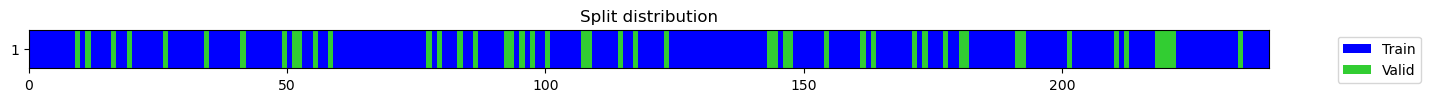

alpha: 1.00E+02  train: 0.92708  valid: 0.79167
[[33.  4.  6.  5.]
 [10. 33.  4.  1.]
 [ 7.  2. 37.  2.]
 [ 6.  1.  4. 37.]]


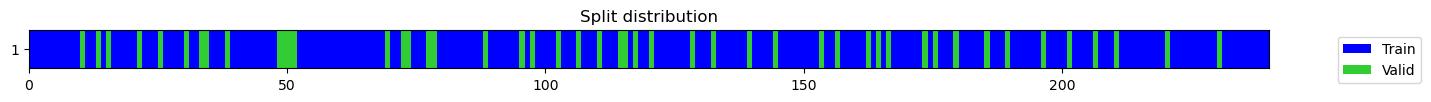

alpha: 1.00E+02  train: 0.92708  valid: 0.66667
[[40.  5.  9.  6.]
 [11. 42.  6.  1.]
 [ 7.  2. 46.  5.]
 [10.  1.  5. 44.]]


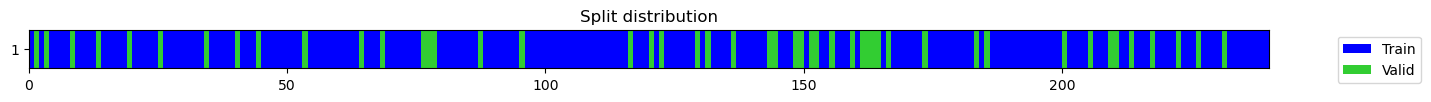

alpha: 1.00E+02  train: 0.94792  valid: 0.68750
[[49.  5. 10.  8.]
 [13. 50.  8.  1.]
 [12.  3. 52.  5.]
 [11.  1.  6. 54.]]


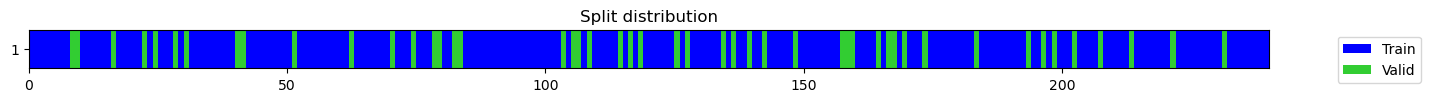

alpha: 1.00E+02  train: 0.94792  valid: 0.66667
[[59.  6. 11.  8.]
 [16. 56. 11.  1.]
 [14.  4. 59.  7.]
 [12.  3.  6. 63.]]


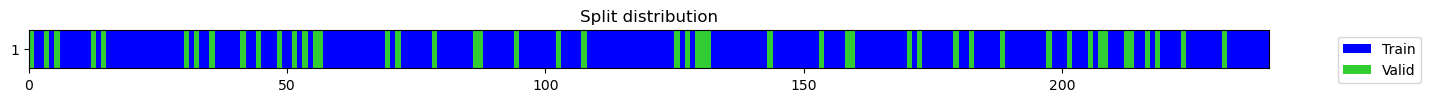

alpha: 1.00E+02  train: 0.92708  valid: 0.70833
[[65.  7. 13. 11.]
 [16. 66. 12.  2.]
 [16.  6. 67.  7.]
 [13.  4.  6. 73.]]


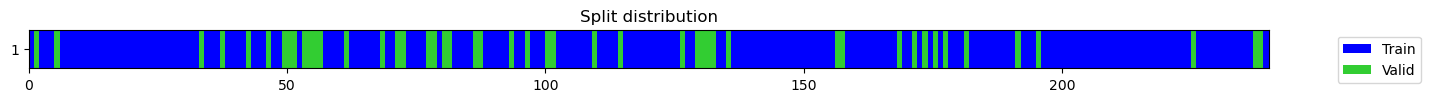

alpha: 1.00E+02  train: 0.94271  valid: 0.81250
[[74.  9. 14. 11.]
 [17. 75. 13.  3.]
 [17.  6. 78.  7.]
 [14.  4.  7. 83.]]


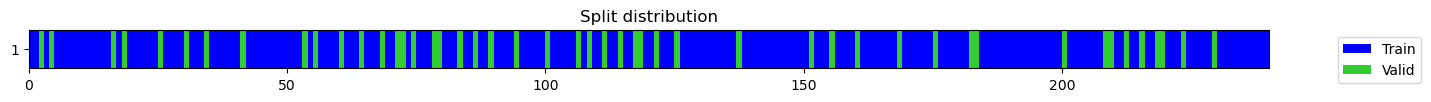

alpha: 1.00E+02  train: 0.94271  valid: 0.68750
[[82. 11. 15. 12.]
 [17. 84. 15.  4.]
 [19.  7. 85.  9.]
 [15.  5.  8. 92.]]


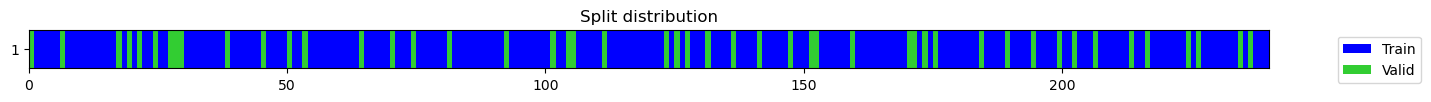

alpha: 1.00E+02  train: 0.94271  valid: 0.72917
[[ 92.  11.  17.  12.]
 [ 18.  94.  16.   4.]
 [ 21.   9.  92.  10.]
 [ 18.   5.   9. 100.]]


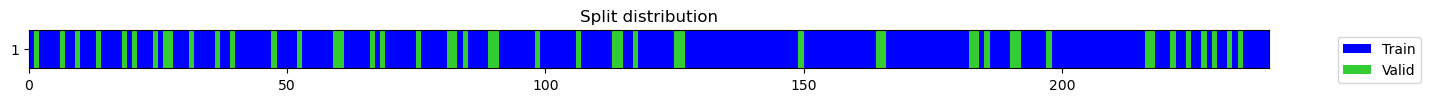

alpha: 1.00E+02  train: 0.94271  valid: 0.77083
[[101.  13.  18.  12.]
 [ 20. 104.  16.   4.]
 [ 23.   9. 101.  11.]
 [ 18.   6.  11. 109.]]


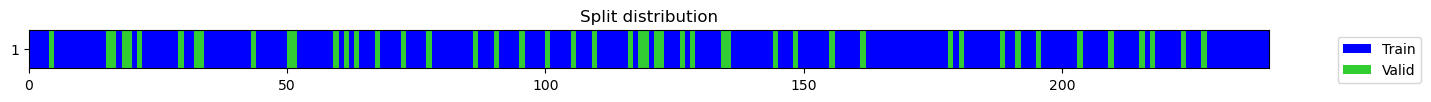

alpha: 1.00E+02  train: 0.91667  valid: 0.66667
[[108.  16.  19.  13.]
 [ 21. 114.  17.   4.]
 [ 25.  10. 109.  12.]
 [ 23.   6.  11. 116.]]


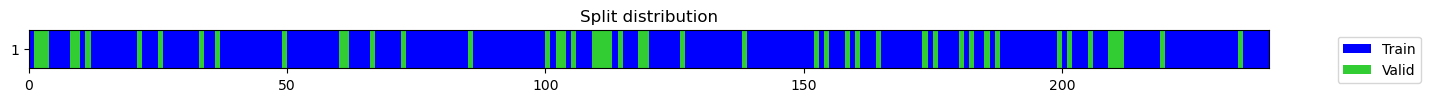

alpha: 1.00E+02  train: 0.92708  valid: 0.70833
[[116.  17.  19.  16.]
 [ 21. 123.  18.   6.]
 [ 29.  10. 117.  12.]
 [ 26.   6.  11. 125.]]


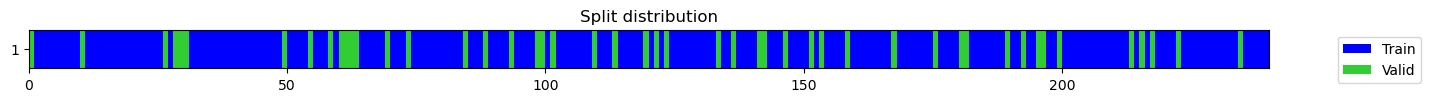

alpha: 1.00E+02  train: 0.93750  valid: 0.79167
[[126.  17.  20.  17.]
 [ 22. 133.  19.   6.]
 [ 29.  11. 127.  13.]
 [ 29.   6.  12. 133.]]


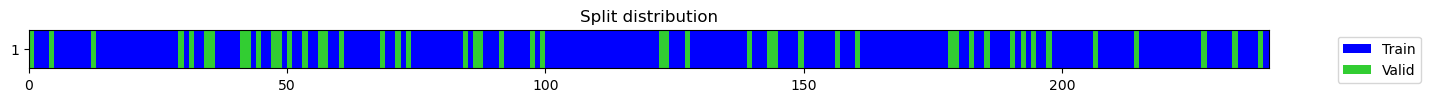

alpha: 1.00E+02  train: 0.91146  valid: 0.79167
[[138.  17.  20.  17.]
 [ 24. 143.  19.   6.]
 [ 31.  12. 135.  14.]
 [ 32.   6.  13. 141.]]


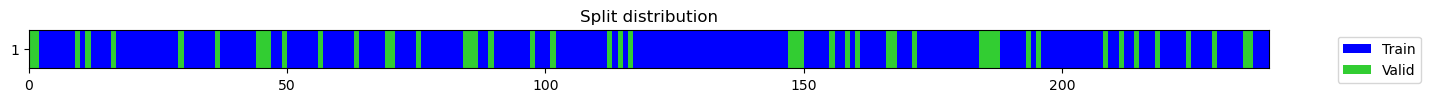

alpha: 1.00E+02  train: 0.92708  valid: 0.68750
[[146.  19.  22.  17.]
 [ 25. 152.  21.   6.]
 [ 34.  12. 142.  16.]
 [ 33.   8.  13. 150.]]


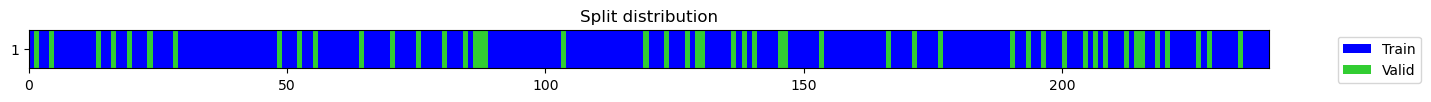

alpha: 1.00E+02  train: 0.93229  valid: 0.72917
[[152.  20.  26.  18.]
 [ 27. 162.  21.   6.]
 [ 34.  14. 151.  17.]
 [ 34.   8.  14. 160.]]


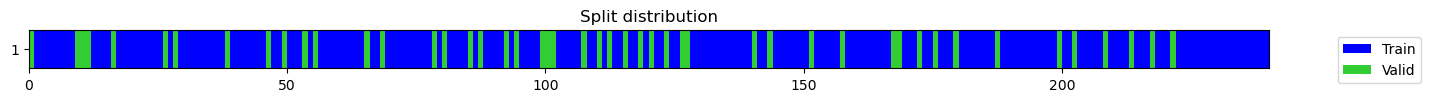

alpha: 1.00E+02  train: 0.93750  valid: 0.72917
[[159.  20.  30.  19.]
 [ 28. 172.  22.   6.]
 [ 36.  15. 159.  18.]
 [ 36.   8.  14. 170.]]


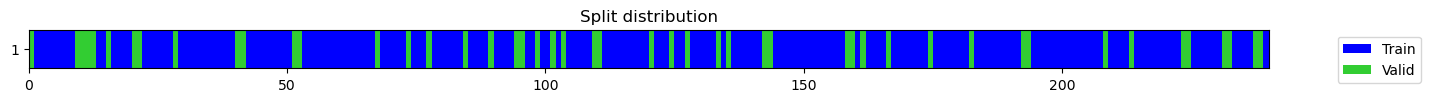

alpha: 1.00E+02  train: 0.92188  valid: 0.77083
[[167.  22.  32.  19.]
 [ 29. 183.  22.   6.]
 [ 37.  17. 166.  20.]
 [ 37.   8.  14. 181.]]
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components


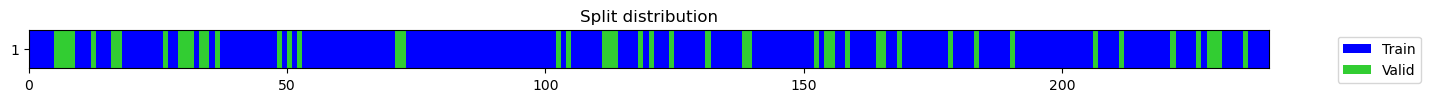

alpha: 1.00E+02  train: 0.92188  valid: 0.75000
[[10.  1.  1.  0.]
 [ 3.  9.  0.  0.]
 [ 3.  2.  7.  0.]
 [ 1.  0.  1. 10.]]


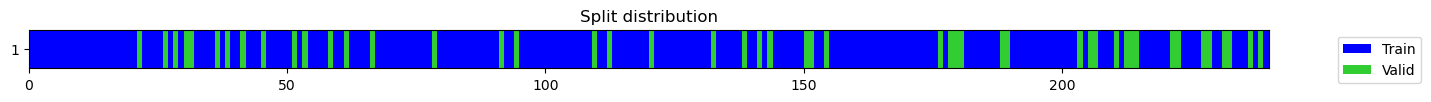

alpha: 1.00E+02  train: 0.93229  valid: 0.68750
[[19.  2.  2.  1.]
 [ 4. 18.  2.  0.]
 [ 6.  4. 14.  0.]
 [ 4.  1.  1. 18.]]


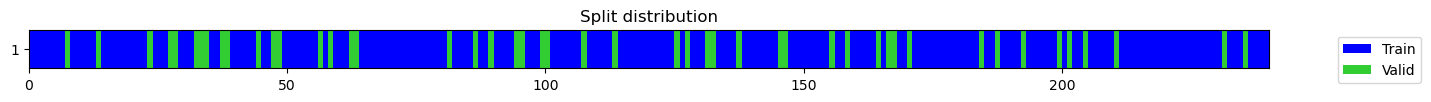

alpha: 1.00E+02  train: 0.94792  valid: 0.75000
[[27.  4.  4.  1.]
 [ 8. 26.  2.  0.]
 [ 7.  4. 25.  0.]
 [ 6.  1.  2. 27.]]


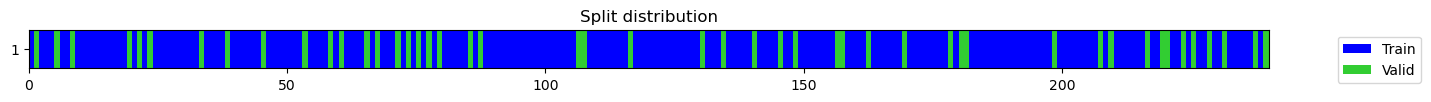

alpha: 1.00E+02  train: 0.91146  valid: 0.72917
[[36.  6.  5.  1.]
 [ 8. 35.  4.  1.]
 [ 9.  5. 32.  2.]
 [ 6.  2.  3. 37.]]


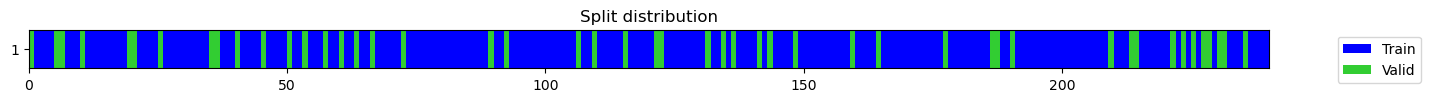

alpha: 1.00E+01  train: 1.00000  valid: 0.66667
[[44.  9.  6.  1.]
 [10. 43.  6.  1.]
 [12.  5. 40.  3.]
 [ 7.  2.  6. 45.]]


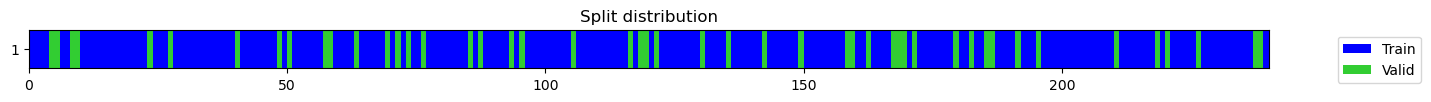

alpha: 1.00E+02  train: 0.93750  valid: 0.62500
[[52. 10.  8.  2.]
 [12. 50.  8.  2.]
 [15.  5. 47.  5.]
 [ 9.  2.  8. 53.]]


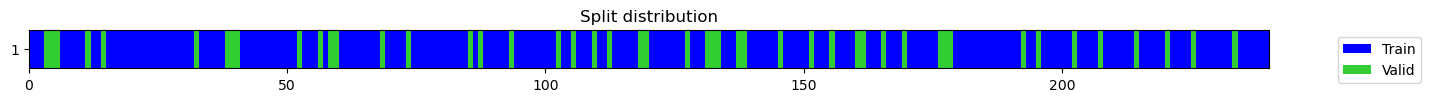

alpha: 1.00E+02  train: 0.94792  valid: 0.66667
[[60. 12.  9.  3.]
 [15. 59.  8.  2.]
 [17.  6. 54.  7.]
 [11.  3.  9. 61.]]


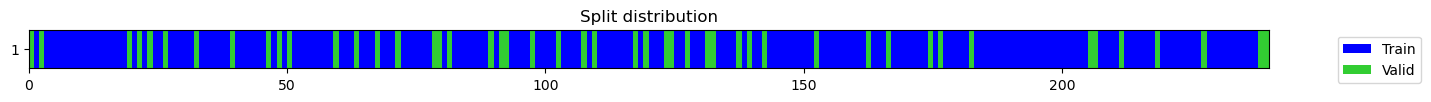

alpha: 1.00E+02  train: 0.93750  valid: 0.75000
[[70. 12. 10.  4.]
 [16. 69.  8.  3.]
 [20.  8. 60.  8.]
 [13.  3.  9. 71.]]


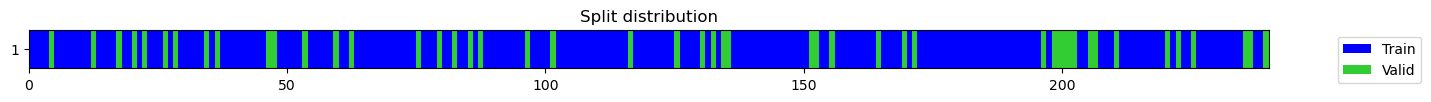

alpha: 1.00E+02  train: 0.92188  valid: 0.75000
[[77. 14. 11.  6.]
 [18. 79.  8.  3.]
 [23.  9. 67.  9.]
 [13.  3.  9. 83.]]


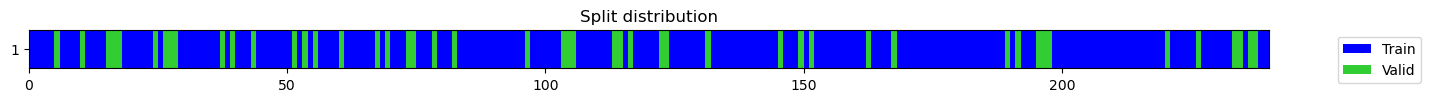

alpha: 1.00E+02  train: 0.95312  valid: 0.64583
[[81. 17. 15.  7.]
 [19. 90.  8.  3.]
 [23. 12. 75. 10.]
 [14.  4. 11. 91.]]


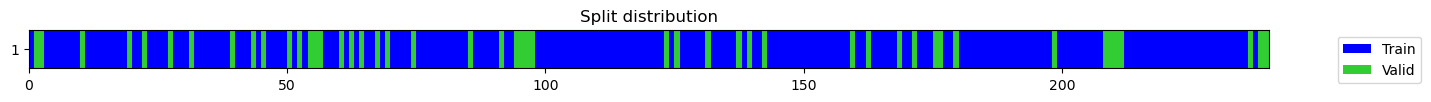

alpha: 1.00E+02  train: 0.94792  valid: 0.81250
[[ 88.  19.  18.   7.]
 [ 19. 101.   9.   3.]
 [ 23.  13.  86.  10.]
 [ 15.   4.  12. 101.]]


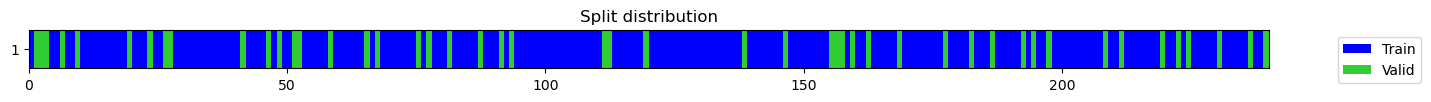

alpha: 1.00E+02  train: 0.94271  valid: 0.79167
[[ 99.  20.  18.   7.]
 [ 19. 109.  12.   4.]
 [ 24.  13.  95.  12.]
 [ 16.   4.  13. 111.]]


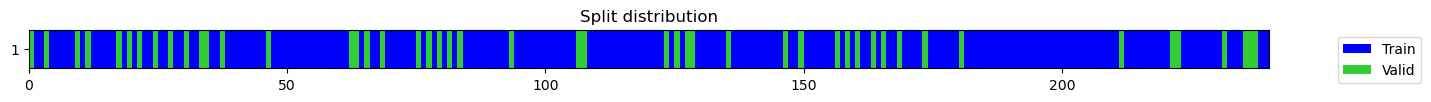

alpha: 1.00E+02  train: 0.93229  valid: 0.77083
[[110.  20.  19.   7.]
 [ 21. 118.  12.   5.]
 [ 29.  14. 101.  12.]
 [ 17.   4.  13. 122.]]


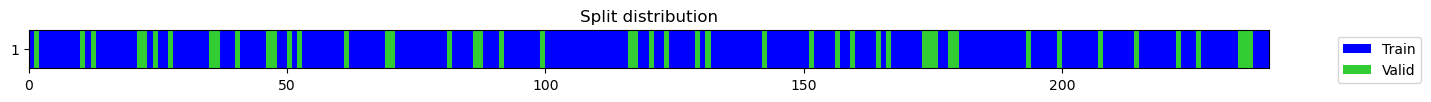

alpha: 1.00E+02  train: 0.93229  valid: 0.72917
[[119.  21.  21.   7.]
 [ 21. 127.  14.   6.]
 [ 31.  16. 109.  12.]
 [ 17.   6.  14. 131.]]


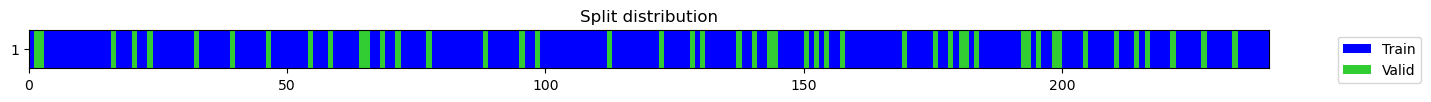

alpha: 1.00E+01  train: 1.00000  valid: 0.58333
[[125.  22.  23.  10.]
 [ 23. 133.  18.   6.]
 [ 34.  16. 115.  15.]
 [ 19.   6.  14. 141.]]


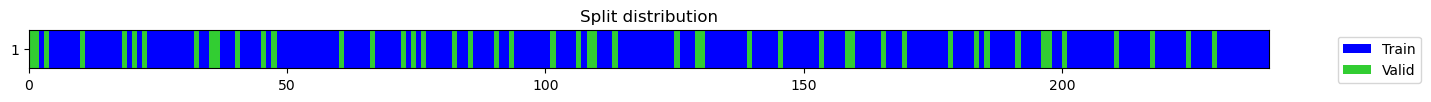

alpha: 1.00E+02  train: 0.93750  valid: 0.79167
[[135.  22.  23.  12.]
 [ 25. 143.  18.   6.]
 [ 36.  18. 123.  15.]
 [ 19.   6.  16. 151.]]


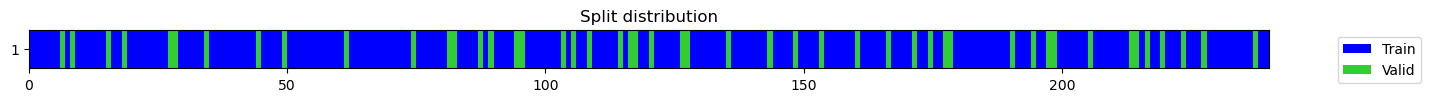

alpha: 1.00E+02  train: 0.92188  valid: 0.72917
[[141.  23.  26.  14.]
 [ 26. 153.  19.   6.]
 [ 38.  19. 132.  15.]
 [ 21.   6.  16. 161.]]


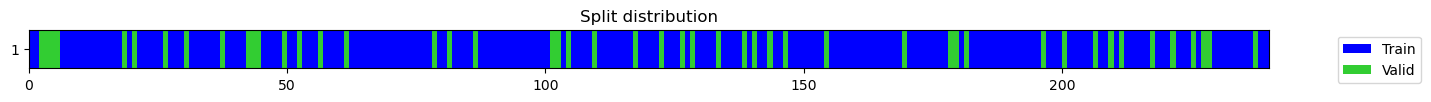

alpha: 1.00E+02  train: 0.91146  valid: 0.70833
[[151.  23.  26.  16.]
 [ 31. 159.  19.   7.]
 [ 40.  19. 141.  16.]
 [ 23.   6.  17. 170.]]


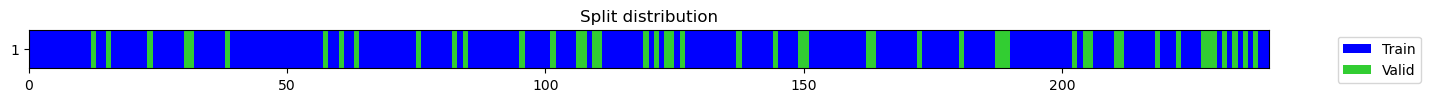

alpha: 1.00E+02  train: 0.91667  valid: 0.77083
[[160.  25.  26.  17.]
 [ 31. 168.  22.   7.]
 [ 40.  19. 150.  19.]
 [ 24.   7.  17. 180.]]


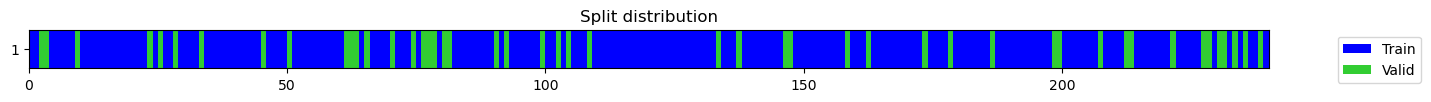

alpha: 1.00E+02  train: 0.92708  valid: 0.58333
[[168.  25.  29.  18.]
 [ 33. 177.  22.   8.]
 [ 44.  20. 155.  21.]
 [ 27.   7.  20. 186.]]


AttributeError: 'list' object has no attribute 'T'

In [188]:
total_acc = []

for idx in [0, 1, 2, 3, 4, 5, 6, 7]:
    muscle_idx = [1]
    ear_raw_removed = ica.apply(ear_raw, exclude = muscle_idx)


    removed_earEEG = ear_raw_removed._data.T.reshape(-1, 200 * sec, 8)
    removed_earEEG.shape

    ear_ele = removed_earEEG.transpose([0, 2, 1])
    y = np.repeat([0,1,2,3], int(ear_ele.shape[0]/4))

    # z-score
    ear_ele = (ear_ele - ear_ele.mean(axis = 2)[...,np.newaxis])\
                    /ear_ele.std(axis = 2)[...,np.newaxis]




    # time frequency analysis for ear-EEG
    temp_ear_ele = []
    for flame in ear_ele:
        _,_,temp = time_frequency_analysis(
            flame.T, srate = new_srate, max_freq = 60, min_freq = 2, 
            num_freq = 59, fwhm = 0.75 * sec)

        temp_ear_ele.append(temp)

    # if use mask
    ear_ele_NOmask = np.asarray(temp_ear_ele)
    # ear_ele_masked = np.asarray(temp_ear_ele)[:,mask,:]
    # print(ear_ele.shape)
    temp_acc, cf_matrix = cross_validation(ear_ele_NOmask,
                                           y, cv_number = 20, test_size = 0.2)
    # pd.concat([pd.read_csv(r'result/ROCKET_ACC_with_mask.csv', header = 0),
    #            pd.DataFrame(np.asarray(temp_acc).reshape(-1, 2), 
    #                         columns=[f'{time_in_sec}s_NOmask', f'{time_in_sec}s_masked'])], 
    #       axis = 1).to_csv(r'result/ROCKET_ACC_with_mask.csv', index= None)

    #     pd.DataFrame(cf_matrix).to_csv(
    #         r'C:\MY\matlab\SSVEP\seesion2\result\ROCKET_cfmatrix_01_13.csv', 
    #         mode = 'a', index = None, header = None)
    total_acc.append(temp_acc)
    
pd.DataFrame(total_acc.T).to_csv(r'C:\MY\matlab\SSVEP\seesion2\result\ROCKET_removed_4s.csv')